# CodeLab4 - Feature Extraction
Feature engineering is the art and science of selecting, transforming, and creating meaningful input features from raw data. Machine learning algorithms can extract valuable patterns and make accurate predictions. This exercise focuses on biomedical images derived from three distinct modalities: chest X-rays, abdomen and head CT scans. [1]–[3]. 

Feature extraction tasks heavily rely on the type of data and the objective. For instance, object detection tasks rely on edge detection, blob detection, and shape descriptors. For more complex tasks, e.g., ML aided diagnosis of pneumonia, convolutional neural networks (CNN) are often employed due to their high performance in image processing. The multi-layer structure remains identical as in neural network, with the main difference being in the learned parameters, which are the kernel weights, as opposed to the neuron weights. Kernels are small windows (filters), which overlap to the input image/data. The element wise products between the kernel weights and the overlapping portion of the input image are added together to produce a new feature map. After each summation step, the filter slides to the next region of the image.

In this lab, you will use a set of selected biomedical images to classify and categorize the dataset. Meanwhile, the effect of the feature selection on the image dataset will be discussed. You will also tell the differences before and after feature engineering. Hyperparameter tuning is also an important factor in the training process of modern ML workflow. A grid search method will be deployed to find the optimal model parameters for this specific task. 

Provide your answers in the Jupyter Notebook either as a comment or insert a markdown cell. Please print out your Jupyter Notebook in PDF format (or HTML) and upload it to Brightspace. You will get points for each part separately, and you will get the grades based on your overall performance. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np

np.random.seed(42)
random.seed(42)

## Task A - Dataset preparation (1 point)

This cell checks if a directory named "dataset" exists. If it does not exist, it opens the zip file named "dataset.zip" and extracts its contents into the "dataset" directory.

In [2]:
import os
import zipfile

if not os.path.exists("dataset"):
    with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
        zip_ref.extractall("dataset")
else:
    print("Dataset already exists, skipping unzip")

Dataset already exists, skipping unzip


Create the path to the dataset folder by merging the current working directory and the folder name.
The variable `data_dir` that stores the path to a directory called `dataset\\` within the current working directory.

>**NOTE**: to run this cell in Vocareum/Google Colab/MacOS/Linux the directory name is `dataset/`, if you run it locally on Windows systems use `dataset\\`

In [3]:
data_dir = os.path.join(os.getcwd(), 'dataset/')
print('Number of images in the dataset folder: ', len(os.listdir(data_dir)))

Number of images in the dataset folder:  400


The folder should contain 400 items, if this is not the case, go back to jupyter interface, delete the dataset folder, and retry from the start of the notebook.

- A1) Complete the `load_data` function. It loads the data from the dataset folder. Four different classes are present in the dataset, and labels will be assigned according to their filenames. Make sure all three different formats of images are imported.
The function `fnmatch` is used to search for a specific string in the filenames, labels should be assigned as follows:

        Abdomen CT scans -> Class 0
        Brain CT scans -> Class 1
        Chest X-Rays normal -> Class 2
        Chest X-rays with pneumonia -> Class 3

In [4]:
from fnmatch import fnmatch

cl_list = ["Abdomen", "Brain", "Chest normal", "Chest Pneumonia"]

def load_data(directory):
    images = []
    labels = []
    for filename in os.listdir(directory): ## iterate over each file in directory
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"): ## check if it is an image
            img = mpimg.imread(directory + filename) ## read image
            images.append(img)        
        ## assign labels based on filename    
        if fnmatch(filename, cl_list[0]+'*'):
            labels.append(0)
        elif fnmatch(filename, cl_list[1]+'*'):
            labels.append(1)
        elif fnmatch(filename, cl_list[2]+'*'):
            labels.append(2)
        elif fnmatch(filename, cl_list[3]+'*'):
            labels.append(3)
        else:
            raise ValueError('Unknown class: %s' % (filename))
    
    return images, np.asarray(labels)

- A2) Load the data using the `load_data()` function and verifiy the sizes of the dataset. It should create 400 samples and 400 labels.

In [5]:
raw_images, labels = load_data("./dataset/")

print(f"size of datasets: {len(raw_images)}")
print(f"size of labels: {len(labels)}")

size of datasets: 400
size of labels: 400


- A3) Plot a random image for each class in the same figure

Hint: you can use the function `random.choice()` to pick from the indexes that correspond to a specific class (`np.where(condition)`)

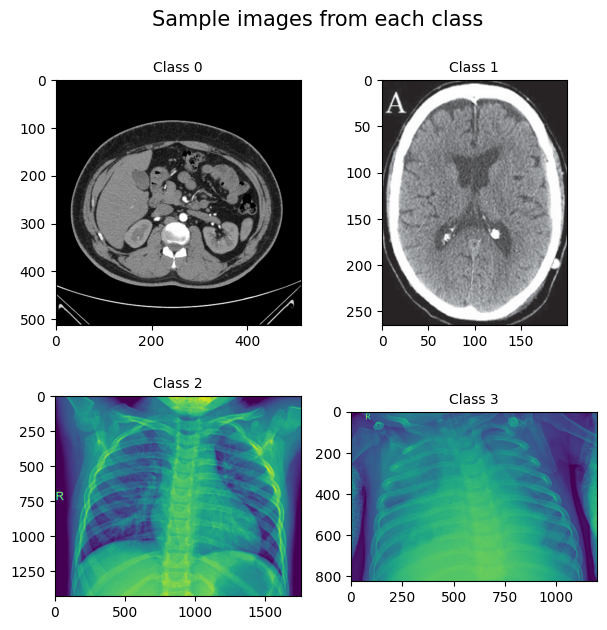

In [6]:
def plot_image_sample(image_list, gray = False):
    plt.figure(figsize=(7,7))
    plt.suptitle('Sample images from each class',fontsize=15)

    plt.subplot(2,2,1)
    plt.imshow(image_list[random.choice(np.where(labels == 0)[0])], cmap='gray' if gray else 'viridis')
    plt.title('Class 0',fontsize=10)

    plt.subplot(2,2,2)
    plt.imshow(image_list[random.choice(np.where(labels == 1)[0])], cmap='gray' if gray else 'viridis')
    plt.title('Class 1',fontsize=10)

    plt.subplot(2,2,3)
    plt.imshow(image_list[random.choice(np.where(labels == 2)[0])], cmap='gray' if gray else 'viridis')
    plt.title('Class 2',fontsize=10)

    plt.subplot(2,2,4)
    plt.imshow(image_list[random.choice(np.where(labels == 3)[0])], cmap='gray' if gray else 'viridis')
    plt.title('Class 3',fontsize=10)

    plt.show()

plot_image_sample(raw_images)


As you can see, the images have different characteristics: some are RGB, some oethers are B&W, and all have varying shapes. For this reason you're going to resize them and convert them in grayscale.

The `convert_to_grayscale` function takes an image as input and converts it to grayscale using the `cv2.cvtColor` function from the OpenCV library. It uses the `cv2.COLOR_BGR2GRAY` flag to specify the conversion from BGR color space to grayscale. The function then returns the grayscale image.

Only the RGB images need to be converted to grayscale, otherwise cv2 will raise an error, so check for this verifying the shape of each image: RGB images can have 3 or 4 channels, one for each colour + transparency in the case of .png files.

The `resize_images_in_list` function takes a list of images and resizes each image to a specified target size. If the image has 3 or 4 channels (indicating it is a color image), it first converts the image to grayscale using the `convert_to_grayscale` function. Then, it resizes the image using the `cv2.resize` function and appends the resized image to a list. Finally, it returns the resized images as a numpy array. The default target size is set to (128,128) if no target size is specified.


In [7]:
import cv2

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) ## convert the image to grayscale
    
def resize_images_in_list(image_list, target_size=(128,128)): ## default target size is 128,128

    resized_images=[]

    for image in image_list:    ## iterate through the list of images

        if image.shape[-1] == 3 or image.shape[-1] == 4: ## check if the last dimension of each image is 3 or 4
            image=convert_to_grayscale(image) ## if needed, convert the image to grayscale

        resized_image = cv2.resize(image, target_size) ## resize the image
        resized_images.append(resized_image) ## append the resized image to the list

    return np.array(resized_images) ## return the resized images as a numpy array
                                                     

- A4) Resize the Image into (128,128) using the `resize_images_in_list` function

In [8]:
resized_images = resize_images_in_list(raw_images)

- A5) Now plot again in the same figure one image from each class to verify that the B&W conversion and resizing has been succesfully performed. 

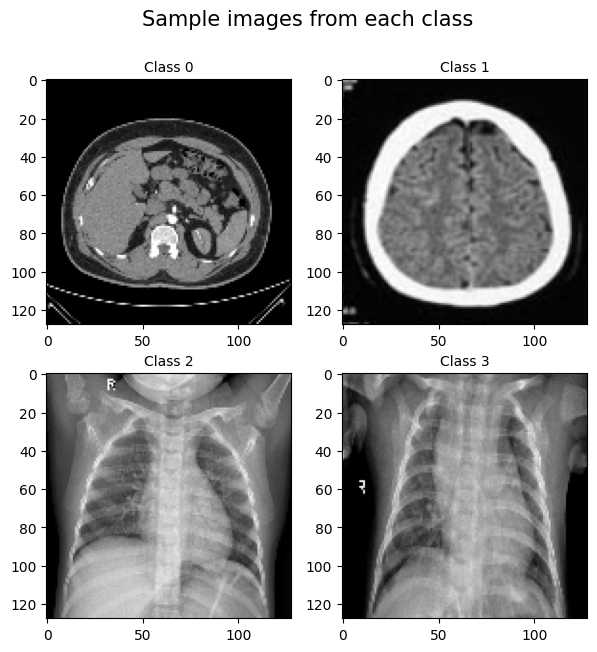

In [9]:
plot_image_sample(resized_images, True)

## Task B - Kernels, Gradients and Convolution (3 points)

Edge detection is a technique used in image processing to identify the boundaries between different objects in an image. It works by detecting sharp changes in brightness or color within an image. These changes are called edges and can be used to segment an image into different regions. Edge detection is often used as a preprocessing step for other computer vision tasks, such as object detection and image segmentation.

In [10]:
matrix = np.array([[0,0,0,0,0,0],[0,1,1,1,1,0],[0,1,1,1,1,0],[0,1,1,1,1,0],[0,1,1,1,1,0],[0,0,0,0,0,0]])

print("Matrix:")
print(matrix)

Matrix:
[[0 0 0 0 0 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 0 0 0 0 0]]


Padding is a technique to increase the spatial dimensions of an input matrix by adding extra rows and columns of zeros around the edges of the input matrix. Padding can prevents loss of information as after a convolution operations the output matrix is smaller than the original one. It can also help to prevent the edges of the input matrix from being ignored by convolution operations. Manually perform the padding operation by adding a row and a column of zeros on all sides of the original matrix.
Look at the given function called `manual_padding` that takes a matrix as an input and returns the padded matrix form.


In [11]:
# Perform manual padding by adding a row and a column of zeros on all sides
def manual_padding(matrix):
    padded_matrix = np.zeros((matrix.shape[0] + 2, matrix.shape[1] + 2), dtype=matrix.dtype)
    padded_matrix[1:-1, 1:-1] = matrix
    return padded_matrix

- B1) Using the given 4x4 matrix of integers to do a zero padding. Padding is made by adding a row and a column on all sides of the original matrix. Print the padded matrix.

In [12]:
padded_matrix = manual_padding(matrix)

print(f"matrix:\n{matrix}")
print(f"\npadded_matrix:\n{padded_matrix}")


matrix:
[[0 0 0 0 0 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 0 0 0 0 0]]

padded_matrix:
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


Pooling operations are used to reduce the spatial dimensions of an input matrix while retaining the most important features. The most common types of pooling operations are max pooling and average pooling.

Max pooling takes the maximum value within a window of a given size and moves the window across the input matrix. This reduces the spatial dimensions of the input matrix while retaining the most important features.

Average pooling takes the average value within a window of a given size and moves the window across the input matrix. This also reduces the spatial dimensions of the input matrix while retaining the most important features.

Pooling operations can help to reduce the number of features used by a model, which can help to prevent overfitting and improve generalization.

Check the `max_pooling` function.

In [13]:
def max_pooling(matrix):
    pool_size = 2
    pooled_matrix = np.zeros((matrix.shape[0] // pool_size + matrix.shape[0] % 2, matrix.shape[1] // pool_size + matrix.shape[1] % 2), dtype=matrix.dtype)
    for i in range(0, matrix.shape[0], pool_size):
        for j in range(0, matrix.shape[1], pool_size):
            window = matrix[i:i+pool_size, j:j+pool_size]
            max_value = np.max(window)
            pooled_matrix[i//pool_size, j//pool_size] = max_value
    return pooled_matrix

- B2) Using the padded matrix you obtained in the last step, perform max pooling with a 2x2 window using the given “max_pooling”. 

In [14]:
max_pooled_matrix = max_pooling(padded_matrix)

print(f"padded_matrix: {padded_matrix}")
print(f"max_pooled_matrix: {max_pooled_matrix}")

padded_matrix: [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
max_pooled_matrix: [[0 0 0 0]
 [0 1 1 0]
 [0 1 1 0]
 [0 0 0 0]]


The code is defining two Sobel kernels for horizontal and vertical edge detection. These kernels are used in image processing to detect edges in an image. The horizontal Sobel kernel is used to detect horizontal edges, while the vertical Sobel kernel is used to detect vertical edges. These kernels are applied to an image using convolution to highlight the edges in the image.

In [15]:
sobel_kernel_horizontal = np.array([[-1, 0, 1],
                                    [-2, 0, 2],
                                    [-1, 0, 1]])

sobel_kernel_vertical = np.array([[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]])


The code defines a function called `convolution` that performs convolution between an input image and a given kernel.


In [16]:
def convolution(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Create an output image with the same dimensions as the input image
    output_image = np.zeros_like(image)

    # Pad the input image to handle boundary pixels
    padding = kernel_width // 2
    padded_image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            # Extract the region of interest (ROI) from the padded image
            roi = padded_image[i:i+kernel_height, j:j+kernel_width]
            
            # Compute the convolution result and store it in the output image
            output_image[i, j] = np.sum(roi * kernel)

    return np.array(output_image, dtype=np.float32)

- B3) Sobel filter is a commonly used filter in image processing. The purpose of using a sobel filter is to extract both the vertical and horizontal edges of the image. The fundamental operation of the sobel filter is convolution. Given both the vertical and horizontal Sobel kernel, Use the convolution function to apply the two kernels to detect the edges.    
“gradient_x” is the result of convolution of sobel horizontal kernel while “gradient_y” is the result of the sobel vertical kernel. 
- B4) Calculate the absolute value of the gradient and its orientation (HINT: Think of them as trigonometric components. `np.arctan2()` returns a value in radians, convert it to degrees.).

In [17]:
gradient_x = convolution(matrix, sobel_kernel_horizontal)
gradient_y = convolution(matrix, sobel_kernel_vertical)

def to_angle(x, y):
    _abs = np.sqrt(x**2 + y**2)
    _angle = np.arctan2(y, x) * 180 / np.pi
    return _abs, _angle

abs_gradient, angle_gradient = to_angle(gradient_x, gradient_y)
angle_gradient = np.arctan2(gradient_y, gradient_x) * 180 / np.pi

print(f"abs_gradient of max_pooled_matrix:\n{abs_gradient}")
print(f"\nangle_gradient of max_pooled_matrix:\n{angle_gradient}")

abs_gradient of max_pooled_matrix:
[[1.4142135 3.1622777 4.        4.        3.1622777 1.4142135]
 [3.1622777 4.2426405 4.        4.        4.2426405 3.1622777]
 [4.        4.        0.        0.        4.        4.       ]
 [4.        4.        0.        0.        4.        4.       ]
 [3.1622777 4.2426405 4.        4.        4.2426405 3.1622777]
 [1.4142135 3.1622777 4.        4.        3.1622777 1.4142135]]

angle_gradient of max_pooled_matrix:
[[  45.         71.56505    90.         90.        108.43495   135.      ]
 [  18.434948   45.         90.         90.        135.        161.56505 ]
 [   0.          0.          0.          0.        179.99998   179.99998 ]
 [   0.          0.          0.          0.        179.99998   179.99998 ]
 [ -18.434948  -45.        -90.        -90.       -135.       -161.56505 ]
 [ -45.        -71.56505   -90.        -90.       -108.43495  -135.      ]]


- B5) Plot the original matrix and the results obtained in the step before in a single plot (1x5 subfigures)
HINT: you can use any colormap for the gradients, for the angles plot use `cmap='twilight'` and plot the colorbar.

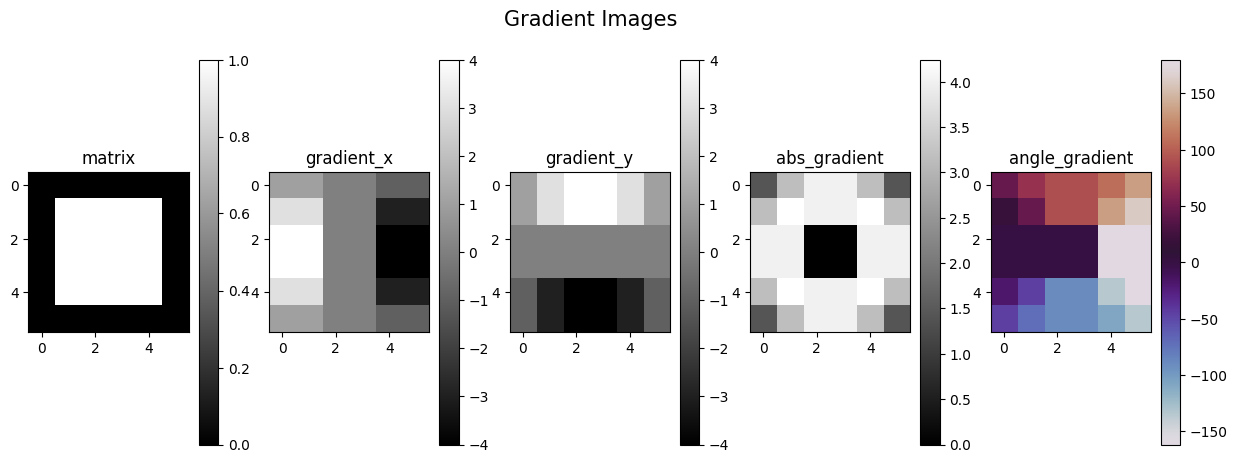

In [18]:
plt.figure(figsize=(15,5))
plt.suptitle('Gradient Images',fontsize=15)

plt.subplot(1,5,1)
plt.imshow(matrix, cmap='gray')
plt.title("matrix")
plt.colorbar()

plt.subplot(1,5,2)
plt.imshow(gradient_x, cmap='gray')
plt.title("gradient_x")
plt.colorbar()

plt.subplot(1,5,3)
plt.imshow(gradient_y, cmap='gray')
plt.title("gradient_y")
plt.colorbar()

plt.subplot(1,5,4)
plt.imshow(abs_gradient, cmap='gray')
plt.title("abs_gradient")
plt.colorbar()

plt.subplot(1,5,5)
plt.imshow(angle_gradient, cmap='twilight')
plt.title("angle_gradient")
plt.colorbar()

plt.show()

Using the  `mpimg.imread()` function, load the "airplane.tiff" image file and:
- B7) compute the horizontal and vertical gradients
- B8) compute the the magnitude of the gradient and its orientation
- B9) perform max pooling on the image and repeat the previous steps (gradients, magnitudes, orientations). 

In [19]:
image = mpimg.imread('./airplane.tiff').astype('int16')

grad_x= convolution(image, sobel_kernel_horizontal)
grad_y= convolution(image, sobel_kernel_vertical)
abs_airplane, angle_airplane = to_angle(grad_x, grad_y)

pooled_image = max_pooling(image)
pooled_grad_x = convolution(pooled_image, sobel_kernel_horizontal)
pooled_grad_y = convolution(pooled_image, sobel_kernel_vertical)
abs_pooled_airplane, angle_pooled_airplane = to_angle(pooled_grad_x, pooled_grad_y)

np.min(angle_airplane)

-179.92917

- B10) plot all the results in a single plot containing all the above results (2x5 subfigures)

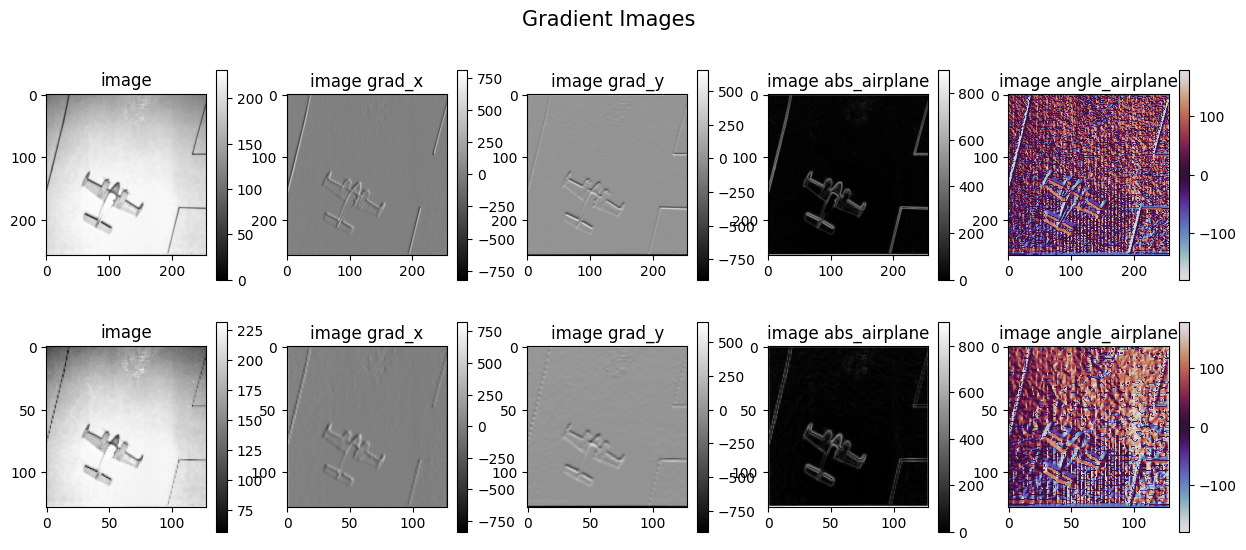

In [20]:
plt.figure(figsize=(15,6))
plt.suptitle('Gradient Images',fontsize=15)

plt.subplot(2, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('image')
plt.colorbar()

plt.subplot(2, 5, 2)
plt.imshow(grad_x, cmap='gray')
plt.title('image grad_x')
plt.colorbar()


plt.subplot(2, 5, 3)
plt.imshow(grad_y, cmap='gray')
plt.title('image grad_y')
plt.colorbar()

plt.subplot(2, 5, 4)
plt.imshow(abs_airplane, cmap='gray')
plt.title('image abs_airplane')
plt.colorbar()

plt.subplot(2, 5, 5)
plt.imshow(angle_airplane, cmap='twilight')
plt.title('image angle_airplane')
plt.colorbar()

plt.subplot(2, 5, 6)
plt.imshow(pooled_image, cmap='gray')
plt.title('image')
plt.colorbar()

plt.subplot(2, 5, 7)
plt.imshow(pooled_grad_x, cmap='gray')
plt.title('image grad_x')
plt.colorbar()


plt.subplot(2, 5, 8)
plt.imshow(pooled_grad_y, cmap='gray')
plt.title('image grad_y')
plt.colorbar()

plt.subplot(2, 5, 9)
plt.imshow(abs_pooled_airplane, cmap='gray')
plt.title('image abs_airplane')
plt.colorbar()

plt.subplot(2, 5, 10)
plt.imshow(angle_pooled_airplane, cmap='twilight')
plt.colorbar()
plt.title('image angle_airplane')

plt.show()

##### Questions
**1. What is the difference between convolution with a kernel and pooling? Hint: Look at the size of the kernels and the resulting images.**

The convolution and the pooling both covers the whole image. The convolution slips its window one pixel at a time whereas the pooling slips it by the size of the kernel. The size after the convolution is the same as the original image, while the size after the pooling is divided by the size of the kernel (for each dimension).

**2. Why two different kernels are used for horizontal and vertical edge detection? Could a single kernel be used for both?**

The edge detection with this method is based on the detection along with a direction by accentuating the gradient in that direction. Therefore, to grasp the edges of a 2D image, the exploration needs to be done along 2 directions (ideally orthogonal!).

**3. What differences can you spot between the pooled and the original image? and in the resulting gradients?**

The pooled one is smaller than the original image, but the results look very similar. However, some edges appear as double lines (which is clearer with *abs* curve) on the pooled version. It could be an amplification of the aliasing that is perceptible in the pooled image.

**4. Although the image is very simple and our brains can infer the edges of the object very simply, why are the resulting edges very noisy? What could be implemented to mitigate the noise?**

The gradient amplification also capture the noise of the image around the edges. Indeed, the edge is not perfectly sharp in the original image, which could be amplified closed to the edge. However, the detection is already pretty good. To clean it up, adding a sigmoid and a noise threshold could sharpen the edge.

## Task 3 - Feature Extraction: Histogram of Gradients and PCA (3 points)

In the context of feature extraction, HOG (Histogram of Oriented Gradients) and PCA (Principal Component Analysis) are two commonly used techniques.

Histogram of Oriented Gradients (HOG) is a feature extraction technique used to detect objects in images. It operates by dividing an image into small cells and then grouping the gradients in each cell according to a specified number of orientations. These grouped gradients, known as histograms, are concatenated to create a feature vector suitable for object detection. The HOG algorithm calculates gradient orientations in localized regions of an image, providing a comprehensive view of the image's gradient structure. To apply HOG, you can use the 'hog' function from the 'sklearn.feature' library, which allows you to extract both the HOG image and its corresponding HOG features. You can also print one of the processed images generated using the HOG technique.    
Hint: The `get_hog` function is a function that calculates the Histogram of Oriented Gradients (HOG) features and images for a given set of images.

In [21]:
from skimage.feature import hog

def get_hog(image_set, size_1, orientations=8):
    hog_images = []
    hog_features = []
    for image in image_set:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(size_1, size_1), cells_per_block=(4,4), visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)

    print(f"size: {size_1}, orientation: {orientations} completed")
    return np.array(hog_features), np.array(hog_images,dtype=np.float32)

- C1) Extract the HOG feature from the dataset, using `size_1=[16,32]` and `orientations=[4, 8]`. 
    >NOTE: computing the HOG features can take up to three minutes.

In [22]:
hog_features_16_4, hog_images_16_4 = get_hog(resized_images, 16, 4) 
hog_features_16_8, hog_images_16_8 = get_hog(resized_images, 16, 8) 
hog_features_32_4, hog_images_32_4 = get_hog(resized_images, 32, 4) 
hog_features_32_8, hog_images_32_8 = get_hog(resized_images, 32, 8) 


size: 16, orientation: 4 completed
size: 16, orientation: 8 completed
size: 32, orientation: 4 completed
size: 32, orientation: 8 completed


- C2) Plot the 250th image of each variant of HOG images, and the shapes of the respective feature vectors.

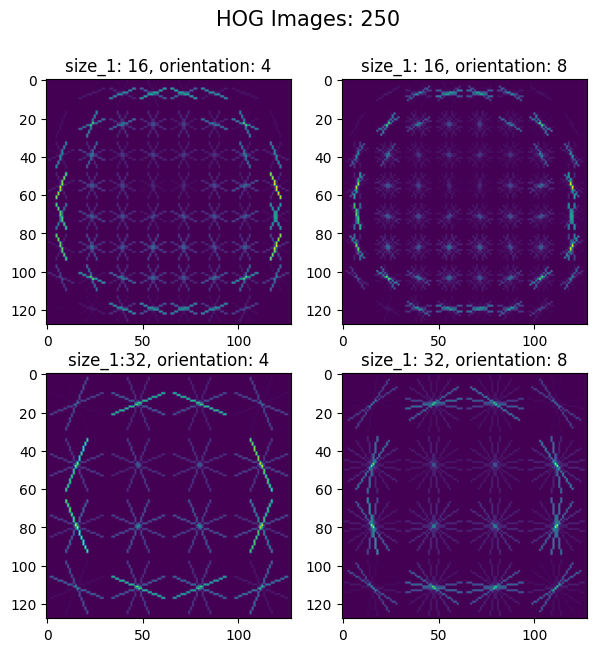

In [23]:
img_id = 250

plt.figure(figsize=(7,7))
plt.suptitle(f'HOG Images: {img_id}',fontsize=15)

plt.subplot(2,2,1)
plt.imshow(hog_images_16_4[img_id])
plt.title(f"size_1: 16, orientation: 4")

plt.subplot(2,2,2)
plt.imshow(hog_images_16_8[img_id])
plt.title(f"size_1: 16, orientation: 8")

plt.subplot(2,2,3)
plt.imshow(hog_images_32_4[img_id])
plt.title(f"size_1:32, orientation: 4")

plt.subplot(2,2,4)
plt.imshow(hog_images_32_8[img_id])
plt.title(f"size_1: 32, orientation: 8")


plt.show()

In [24]:
print(f"shape of hog_features_16_4 {hog_features_16_4.shape}")
print(f"shape of hog_features_16_8 {hog_features_16_8.shape}")
print(f"shape of hog_features_32_4 {hog_features_32_4.shape}")
print(f"shape of hog_features_32_8 {hog_features_32_8.shape}")

shape of hog_features_16_4 (400, 1600)
shape of hog_features_16_8 (400, 3200)
shape of hog_features_32_4 (400, 64)
shape of hog_features_32_8 (400, 128)


Principal Component Analysis (PCA) is a fundamental method in machine learning used for constructing features and dimensionality reduction. In this section, you will utilize the PCA function from 'sklearn.decomposition' to extract features from the provided dataset. PCA identifies the principal components of a dataset, which represent the directions in which the data exhibits the most variation. By projecting a feature vector onto a lower-dimensional subspace defined by these principal components, PCA effectively reduces the dimensionality of the data while retaining the essential information capturing the primary data variations.

- C3) Apply `PCA` to the resized dataset. Hint: `PCA` works in one dimension only, so reshape the images accordingly.
- C4) Plot (scatter) the first two components of the PCA transformed features.

In [25]:
from sklearn.decomposition import PCA

x_flattened = [np.ravel(im) for im in resized_images]

pca = PCA()
pca.fit(x_flattened)
x_pca = pca.transform(x_flattened)

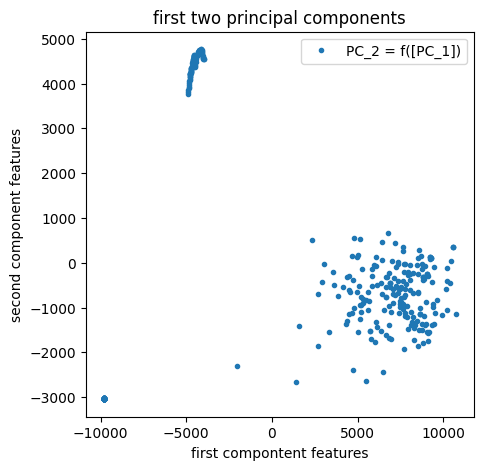

In [26]:
# # Plot the first two principal components of each point
plt.figure(figsize=(5,5))
plt.plot(x_pca[:,0], x_pca[:,1], '.', label="PC_2 = f([PC_1])")
plt.xlabel("first compontent features")
plt.ylabel("second component features")
plt.title('first two principal components')
plt.legend()
plt.show()

- C5) Plot the explained variance ratio and cumulative explained variance ratio of the first 20 components.

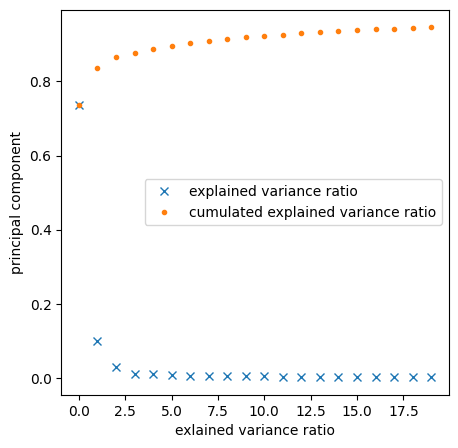

In [27]:
evr = pca.explained_variance_ratio_[:20]
evr_cum = np.cumsum(evr)

plt.figure(figsize=(5,5))

plt.plot(evr, 'x', label = 'explained variance ratio')
plt.plot(evr_cum, '.', label = 'cumulated explained variance ratio')
plt.ylabel("principal component")
plt.xlabel("exlained variance ratio")
plt.legend()
plt.show()

#### Questions:
**1. What did you notice between the HOG images extracted using 16 or 32 pixels/cell? Relate to feature vector(s) sizes and compare it with the original flattened images.**

 The number of features is size_1 * orientation (at most 256 = 8 * 32) remains orders of magnitude lower than the number of features of the flattened images (128 * 128 ~ 16M). The HOG operation reduces significantly the number of features while preserving the required information for a classification.

**2. How does the model performance vary between generated HOG images?**
The more pixels in the cell there are, the smaller the feature vector sizes are. And moreover, the intensity of the angle bins of the HOG are less differentiated with bigger cells. There is a trade-off to handle between the tuning of the feature reduction operated by the HOG transformation and the expected performances of the subsequent classification.

**3. In the PCA plot, what do you observe in the two-component plot?**

There are 3 clusters:
- on the bottom left - which is very precise, almost reduced to a single point
- on the top left - which is pretty precise
- on the bottom right - which is cloudy.

**4. Can you relate the description of Classes 2 and 3 in the dataset, with the behavior highlighted by the previous question?**

The last cluster represents the class 2 and 3: the information to retrieve for the classification is more complex as the images of both classes are very similar.

**5. What does the explained variance of each component represent?**

It explains the contribution of the component to the information embedded in the original image. The higher the variance of a component, the more the component helps in differentiating the original image from the others.

The cumulated explained variance shows that with a pretty small number of components, a large part of the variance of the input data can be capture.

## Task D - Model Training (3 points)

In this task you are going to classify images and the related extracted features . We will define a function “Classifier” that fits the classification model, compute Accuracy, Recall, Precision, F1, and AUC and plot the confusion matrix.    

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,f1_score, precision_score, roc_auc_score, recall_score, confusion_matrix
import seaborn as sns

The code defines a function called `Classifier` that takes as input parameters: `clf` (a classifier object), `x_train` (the training data features), `y_train` (the training data labels), `x_test` (the test data features), and `y_test` (the test data labels).

- D1) Complete the `Classifier` function so that:
    - The input model is fitted to the given data, and predictions are made on the test data.
    - The following metrics are computed with respect to the test data and printed:
        - Accuracy
        - Precision
        - Recall
        - F1 Score.
    >Note: for these last 3 metrics, when computing include the argument `average='macro'`.
    - The confusion matrix is plotted and displayed.

In [29]:
def Classifier(clf,x_train,y_train,x_test,y_test, title):

    #fit the model
    clf.fit(x_train, y_train)

    #predict on the test set
    y_pred = clf.predict(x_test)

    # print the scores
    print(f"Model: {title}")
    print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
    print(f"precision_score: {precision_score(y_test, y_pred, average='macro')}")
    print(f"recall_score: {recall_score(y_test, y_pred, average='macro')}")
    print(f"f1_score: {f1_score(y_test, y_pred, average='macro')}")
    
    # plot the confusion matrix

    plt.figure(figsize=(5,5))

    sns.heatmap(confusion_matrix(y_test, y_pred))
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.title("confusion matrix")
    plt.show()

> From now on, when creating train/test splits, use `test_size=0.2, random_state=42`

- D2) train the following models on the flattened image data:
    - k-NN, using as `n_neighbors=[3,4,5]`
    - SVM, changing between `kernels=['linear','poly','rbf']`, when using poly use degree=3.  
    For all kernels use `[gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3]`. 
    - MLP, changing the `hidden_layer_sizes=[(100),(100,100),(100,100,100)]`.  
    For the remaining parameters always use `[activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42]`

In [30]:
x_train_resized, x_test_resized, y_train_resized, y_test_resized = train_test_split(x_flattened, labels, test_size=0.2, random_state=42)
x_train_flattened, x_test_flattened, y_train_flattened, y_test_flattened = train_test_split(x_flattened, labels, test_size=0.2, random_state=42)

def train(x_train, y_train, x_test, y_test):
    np_x_train  = np.array(x_train)
    np_y_train = np.array(y_train)
    np_x_test = np.array(x_test)
    np_y_test =  np.array(y_test)

    ### knn
    for i in range(3,6):
        clf = KNeighborsClassifier(n_neighbors=i)
        Classifier(clf, np_x_train, np_y_train, np_x_test, np_y_test, f"knn-{i}")


    ### svc
    for kernel in ['linear', 'poly', 'rbf']:
        dic_param = {'kernel':kernel, 'gamma':'auto', 'random_state': 42, 'C': 1.0, 'coef0':0.0, 'tol':1e-3}
        if kernel == 'poly':
            dic_param['degree'] = 3
        clf = SVC(**dic_param)
        Classifier(clf, np_x_train, np_y_train, np_x_test, np_y_test, f"SVC-{kernel}")

    ### mlp
    for hls in [(100), (100,100), (100,100,100)]:
        clf = MLPClassifier(hls, activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
        Classifier(clf, np_x_train, np_y_train, np_x_test, np_y_test, f"MLP: {hls}")
        


Model: knn-3
accuracy_score: 0.9
precision_score: 0.9045454545454545
recall_score: 0.9045454545454545
f1_score: 0.9045454545454547


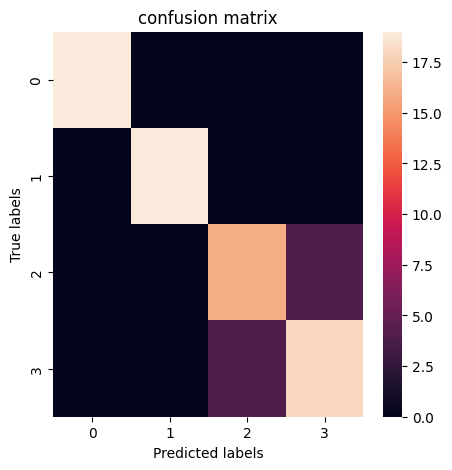

Model: knn-4
accuracy_score: 0.9
precision_score: 0.9045454545454545
recall_score: 0.9045454545454545
f1_score: 0.9045454545454547


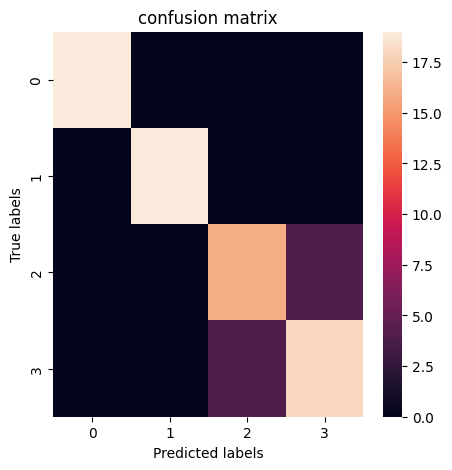

Model: knn-5
accuracy_score: 0.8875
precision_score: 0.8930205949656751
recall_score: 0.8920454545454546
f1_score: 0.8923076923076922


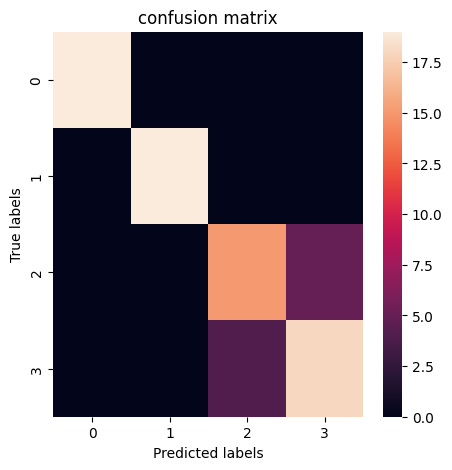

Model: SVC-linear
accuracy_score: 0.925
precision_score: 0.9423076923076923
recall_score: 0.9318181818181819
f1_score: 0.9279176201372998


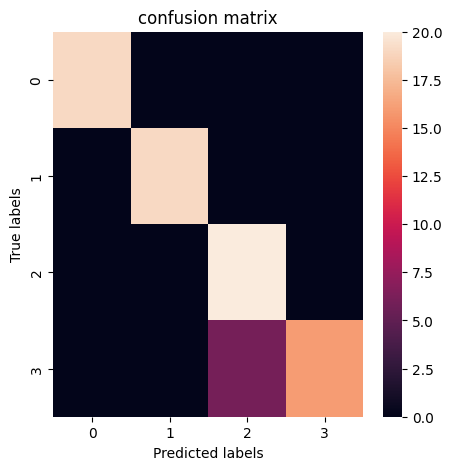

Model: SVC-poly
accuracy_score: 0.95
precision_score: 0.9583333333333334
recall_score: 0.9545454545454546
f1_score: 0.9522727272727273


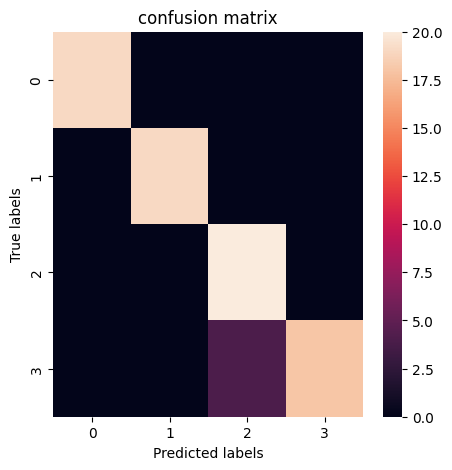

Model: SVC-rbf
accuracy_score: 0.5125
precision_score: 0.5818965517241379
recall_score: 0.5340909090909091
f1_score: 0.43337662337662336


/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


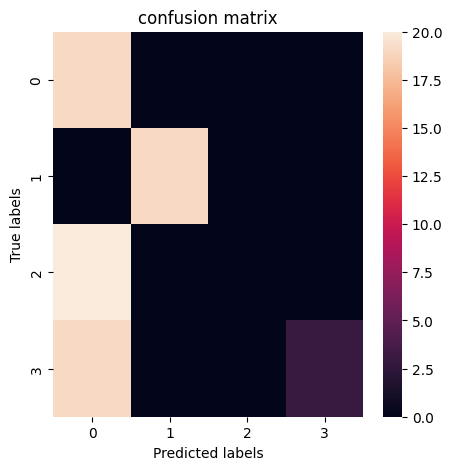

Model: MLP: 100
accuracy_score: 0.675
precision_score: 0.8321881606765328
recall_score: 0.6722488038277511
f1_score: 0.6098819202477739


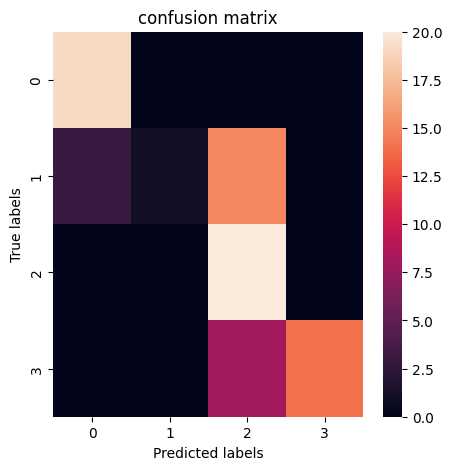

Model: MLP: (100, 100)
accuracy_score: 0.8125
precision_score: 0.8778280542986425
recall_score: 0.8205741626794258
f1_score: 0.8187349687349686


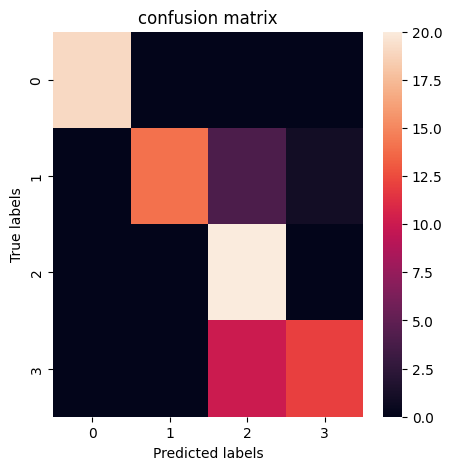

Model: MLP: (100, 100, 100)
accuracy_score: 0.85
precision_score: 0.8770833333333334
recall_score: 0.8476674641148325
f1_score: 0.849496162725401


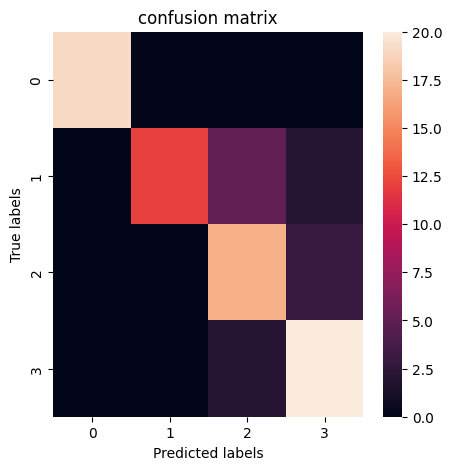

In [31]:
train(x_train_resized, y_train_resized, x_test_resized, y_test_resized)

# Resized

| Model              | accuracy_score | precision_score | recall_score | f1_score         |
|--------------------|----------------|-----------------|--------------|------------------|
| knn-3              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-4              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-5              | 0.8875         | 0.8930          | 0.8920       | 0.8923           |
| SVC-linear         | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| SVC-poly           | 0.95           | 0.9583          | 0.9545       | 0.9523           |
| SVC-rbf            | 0.5125         | /!\ 0.5819 /!\  | 0.5341       | 0.4334           |
| MLP: 100           | 0.675          | 0.8322          | 0.6722       | 0.6099           |
| MLP: (100, 100)    | 0.8125         | 0.8778          | 0.8206       | 0.8187           |
| MLP: (100, 100, 100)| 0.85           | 0.8771          | 0.8477       | 0.8495           |



Model: knn-3
accuracy_score: 0.9
precision_score: 0.9045454545454545
recall_score: 0.9045454545454545
f1_score: 0.9045454545454547


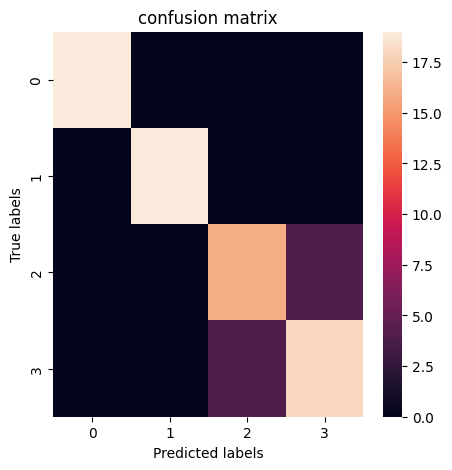

Model: knn-4
accuracy_score: 0.9
precision_score: 0.9045454545454545
recall_score: 0.9045454545454545
f1_score: 0.9045454545454547


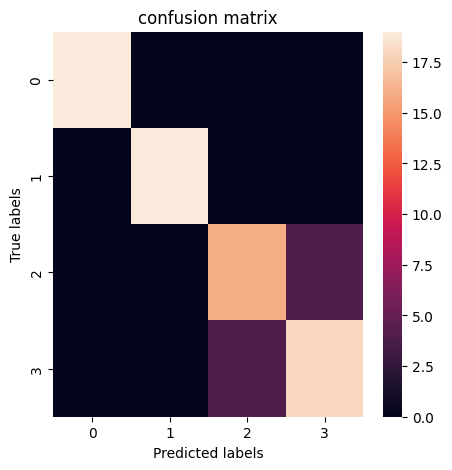

Model: knn-5
accuracy_score: 0.8875
precision_score: 0.8930205949656751
recall_score: 0.8920454545454546
f1_score: 0.8923076923076922


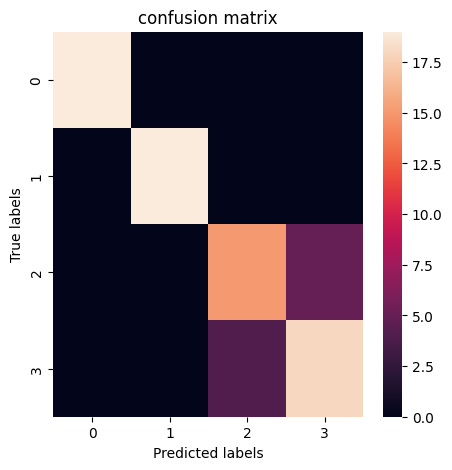

Model: SVC-linear
accuracy_score: 0.925
precision_score: 0.9423076923076923
recall_score: 0.9318181818181819
f1_score: 0.9279176201372998


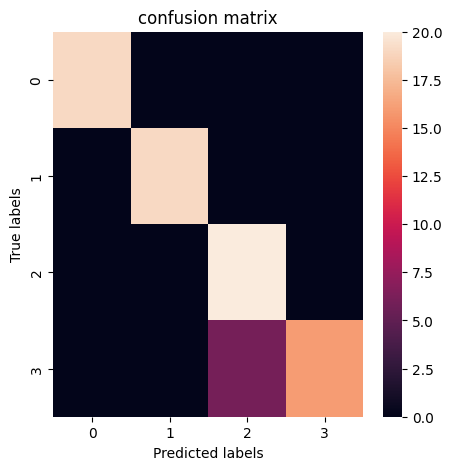

Model: SVC-poly
accuracy_score: 0.95
precision_score: 0.9583333333333334
recall_score: 0.9545454545454546
f1_score: 0.9522727272727273


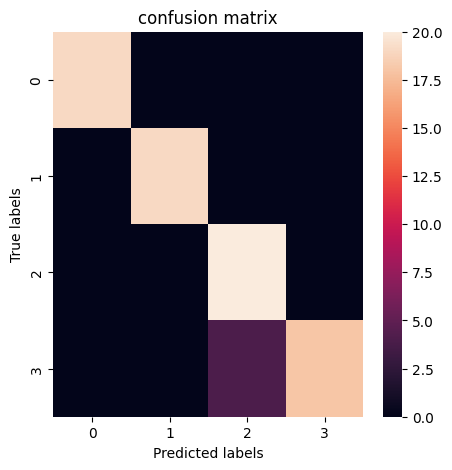

Model: SVC-rbf
accuracy_score: 0.5125
precision_score: 0.5818965517241379
recall_score: 0.5340909090909091
f1_score: 0.43337662337662336


/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


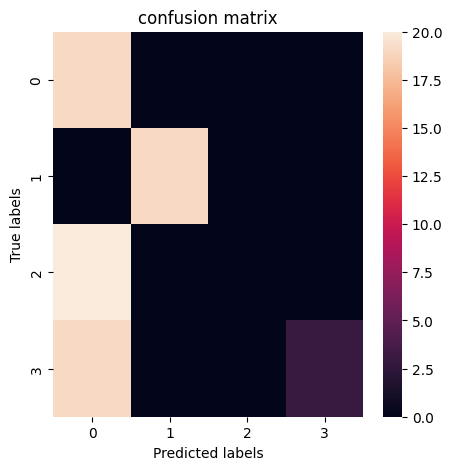

Model: MLP: 100
accuracy_score: 0.675
precision_score: 0.8321881606765328
recall_score: 0.6722488038277511
f1_score: 0.6098819202477739


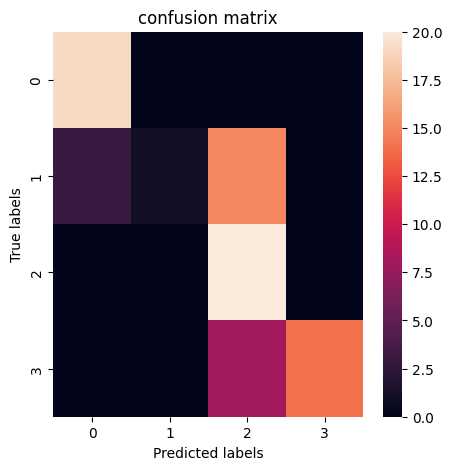

Model: MLP: (100, 100)
accuracy_score: 0.8125
precision_score: 0.8778280542986425
recall_score: 0.8205741626794258
f1_score: 0.8187349687349686


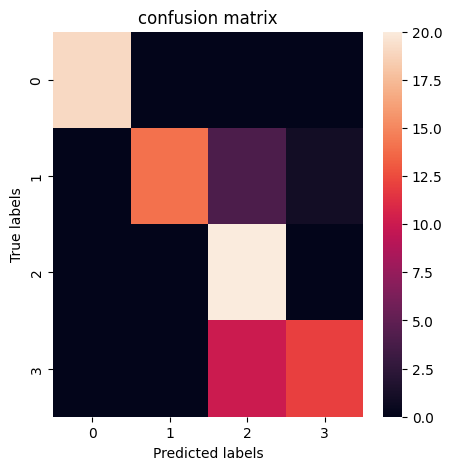

Model: MLP: (100, 100, 100)
accuracy_score: 0.85
precision_score: 0.8770833333333334
recall_score: 0.8476674641148325
f1_score: 0.849496162725401


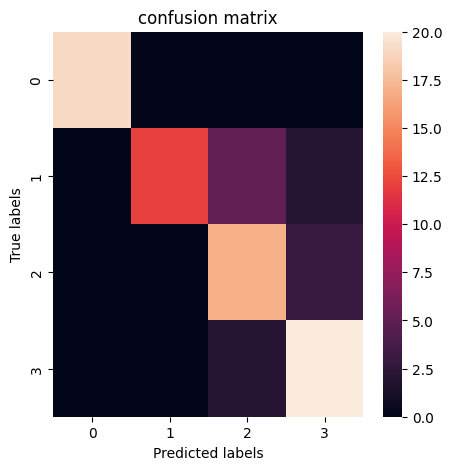

In [32]:
train(x_train_flattened, y_train_flattened, x_test_flattened, y_test_flattened)

### Flattened

| Model              | accuracy_score | precision_score | recall_score | f1_score         |
|--------------------|----------------|-----------------|--------------|------------------|
| knn-3              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-4              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-5              | 0.8875         | 0.8930          | 0.8920       | 0.8923           |
| SVC-linear         | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| SVC-poly           | 0.95           | 0.9583          | 0.9545       | 0.9523           |
| SVC-rbf            | 0.5125         | /!\ 0.5819 /!\  | 0.5341       | 0.4334           |
| MLP: 100           | 0.675          | 0.8322          | 0.6722       | 0.6099           |
| MLP: (100, 100)    | 0.8125         | 0.8778          | 0.8206       | 0.8187           |
| MLP: (100, 100, 100)| 0.85           | 0.8771          | 0.8477       | 0.8495           |


- D3) Using the 4 sets of HOG features obtained before, repeat the training process on new classifier instances, this time use:
    - kNN, with `neighbors=4`
    - SVC, with  `kernel='linear'`  
    Again use `[gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3]`. 
    - MLP, with `hidden_layer_size=(100)`  
    For the remaining parameters always use `[activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42]`

In [33]:
data_hog_16_4 = train_test_split(hog_features_16_4, labels, test_size=0.2, random_state=42)
data_hog_16_8 = train_test_split(hog_features_16_8, labels, test_size=0.2, random_state=42)
data_hog_32_4 = train_test_split(hog_features_32_4, labels, test_size=0.2, random_state=42)
data_hog_32_8 = train_test_split(hog_features_32_8, labels, test_size=0.2, random_state=42)

def train_hog(x_train, x_test, y_train, y_test, hog_suffix):
    np_x_train  = np.array(x_train)
    np_y_train = np.array(y_train)
    np_x_test = np.array(x_test)
    np_y_test =  np.array(y_test)
    
    clf = KNeighborsClassifier(4)
    Classifier(clf, np_x_train, np_y_train, np_x_test, np_y_test, f"hog {hog_suffix}: knn")
    clf = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
    Classifier(clf, np_x_train, np_y_train, np_x_test, np_y_test, f"hog {hog_suffix}: SVC")
    clf = MLPClassifier((100), activation='relu', solver='adam', alpha=0.0001, max_iter=200, random_state=42)


Model: hog 16_4: knn
accuracy_score: 0.8875
precision_score: 0.9092592592592592
recall_score: 0.8965909090909091
f1_score: 0.8913168487636574


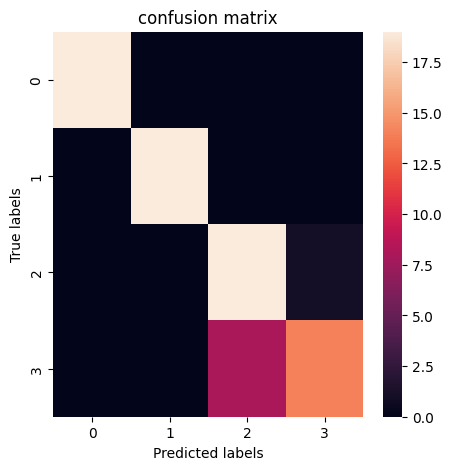

Model: hog 16_4: SVC
accuracy_score: 0.9375
precision_score: 0.95
recall_score: 0.9431818181818181
f1_score: 0.9401709401709402


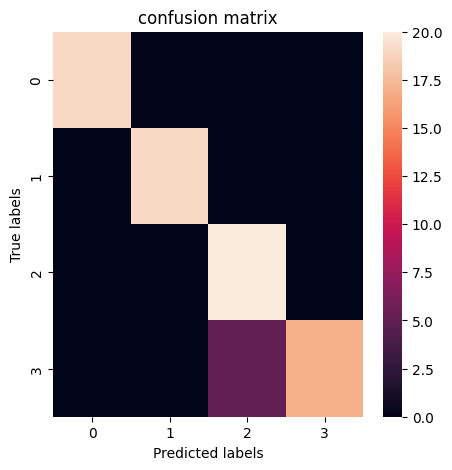

Model: hog 16_8: knn
accuracy_score: 0.8625
precision_score: 0.8945623342175066
recall_score: 0.8738636363636364
f1_score: 0.8653061224489795


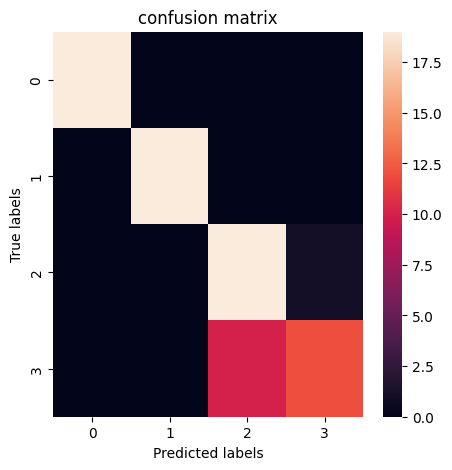

Model: hog 16_8: SVC
accuracy_score: 0.9375
precision_score: 0.95
recall_score: 0.9431818181818181
f1_score: 0.9401709401709402


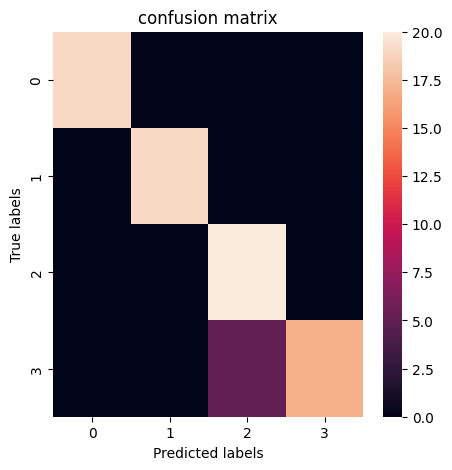

Model: hog 32_4: knn
accuracy_score: 0.925
precision_score: 0.9423076923076923
recall_score: 0.9318181818181819
f1_score: 0.9279176201372998


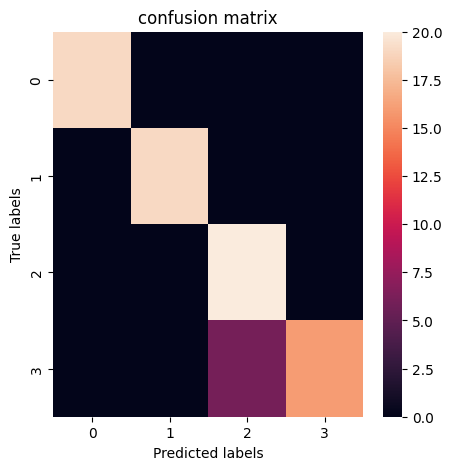

Model: hog 32_4: SVC
accuracy_score: 0.8875
precision_score: 0.9224137931034483
recall_score: 0.8977272727272727
f1_score: 0.889795918367347


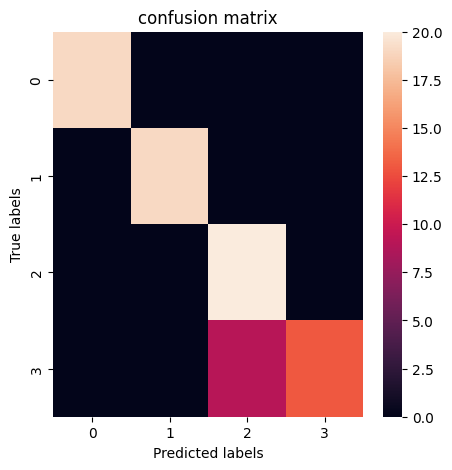

Model: hog 32_8: knn
accuracy_score: 0.925
precision_score: 0.9423076923076923
recall_score: 0.9318181818181819
f1_score: 0.9279176201372998


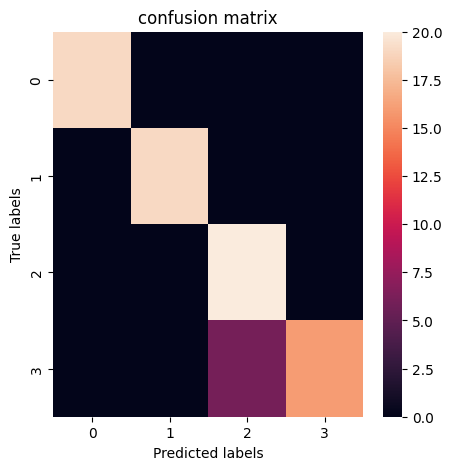

Model: hog 32_8: SVC
accuracy_score: 0.9
precision_score: 0.9285714285714286
recall_score: 0.9090909090909091
f1_score: 0.9027777777777777


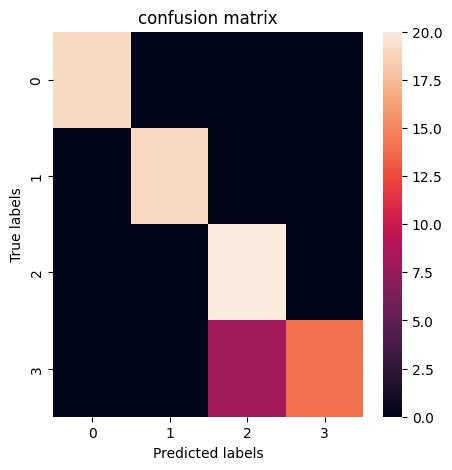

In [34]:
train_hog(*data_hog_16_4, '16_4')
train_hog(*data_hog_16_8, '16_8')
train_hog(*data_hog_32_4, '32_4')
train_hog(*data_hog_32_8, '32_8')

### Hog results
| Model               | accuracy_score | precision_score | recall_score | f1_score         |
|---------------------|----------------|-----------------|--------------|------------------|
| hog 16_4: knn       | 0.8875         | 0.9093          | 0.8966       | 0.8913           |
| hog 16_4: SVC       | 0.9375         | 0.95            | 0.9432       | 0.9402           |
| hog 16_8: knn       | 0.8625         | 0.8946          | 0.8739       | 0.8653           |
| hog 16_8: SVC       | 0.9375         | 0.95            | 0.9432       | 0.9402           |
| hog 32_4: knn       | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| hog 32_4: SVC       | 0.8875         | 0.9224          | 0.8977       | 0.8898           |
| hog 32_8: knn       | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| hog 32_8: SVC       | 0.9            | 0.9286          | 0.9091       | 0.9028           |


- D4) Now repeat the training step using the PCA features, using:
    - kNN, with `neighbors=4`
    - SVC, with  `kernel='linear'`
    - MLP, with `hidden_layer_size=(100)`  
    again use for the remaining parameters always use `[activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42]`

>Train all models first using only the first two PCA components, then the first 10, then all.

Model: PCA-knn : 2 compontents
accuracy_score: 0.7625
precision_score: 0.7796296296296297
recall_score: 0.7772727272727273
f1_score: 0.7705577918343876


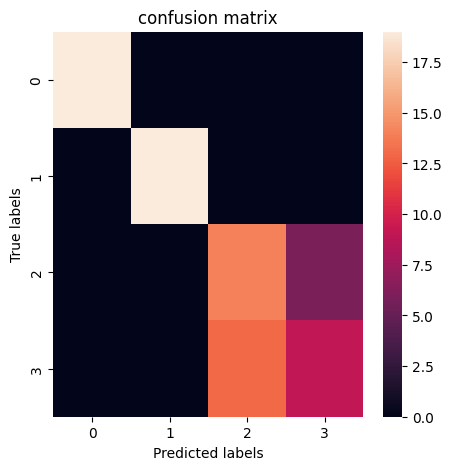

Model: PCA-knn : 10 compontents
accuracy_score: 0.8875
precision_score: 0.8928571428571428
recall_score: 0.8931818181818181
f1_score: 0.8927963698241633


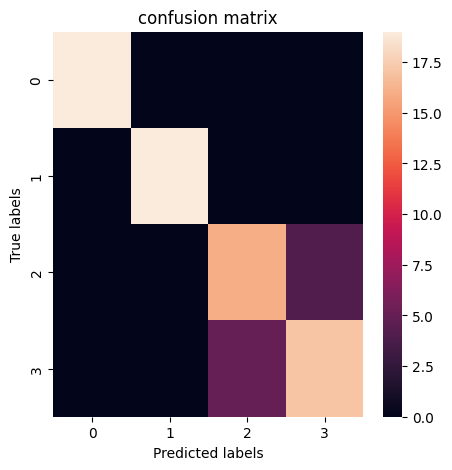

Model: PCA-knn : all compontents
accuracy_score: 0.9
precision_score: 0.9045454545454545
recall_score: 0.9045454545454545
f1_score: 0.9045454545454547


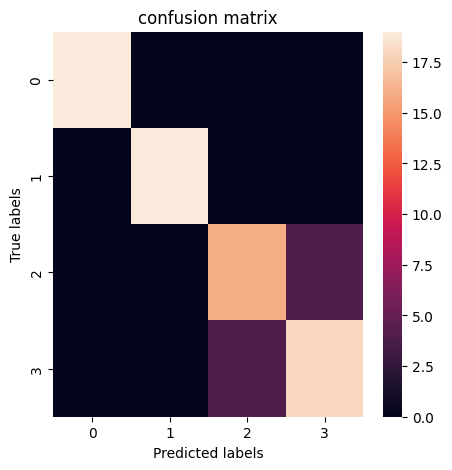

Model: PCA-svc : 2 compontents
accuracy_score: 0.75
precision_score: 0.6309523809523809
recall_score: 0.75
f1_score: 0.671875


/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


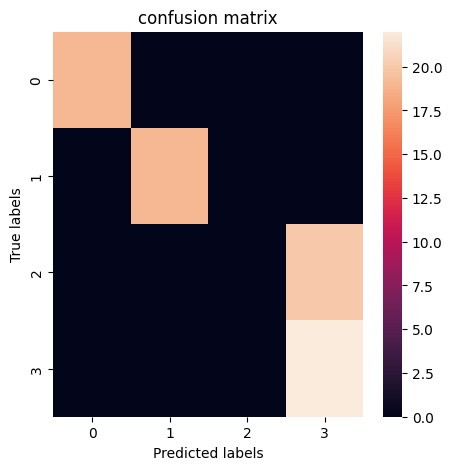

Model: PCA-svc : 10 compontents
accuracy_score: 0.8875
precision_score: 0.8953089244851258
recall_score: 0.8943181818181818
f1_score: 0.8927963698241634


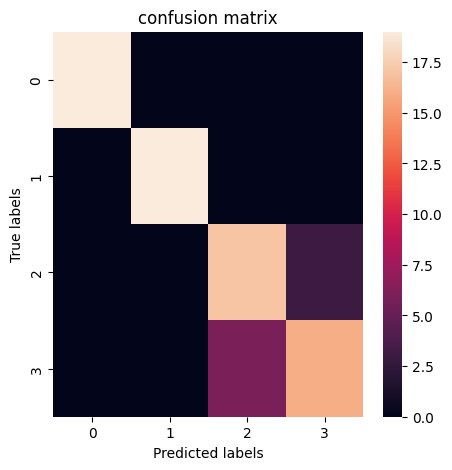

Model: PCA-svc : all compontents
accuracy_score: 0.925
precision_score: 0.9423076923076923
recall_score: 0.9318181818181819
f1_score: 0.9279176201372998


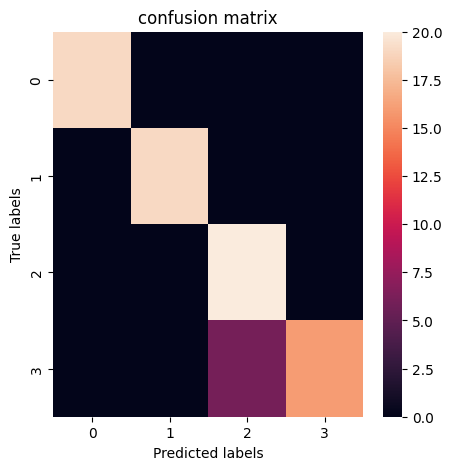

Model: PCA-mlp : 2 compontents
accuracy_score: 0.4875
precision_score: 0.24404761904761904
recall_score: 0.5
f1_score: 0.3279569892473118


/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


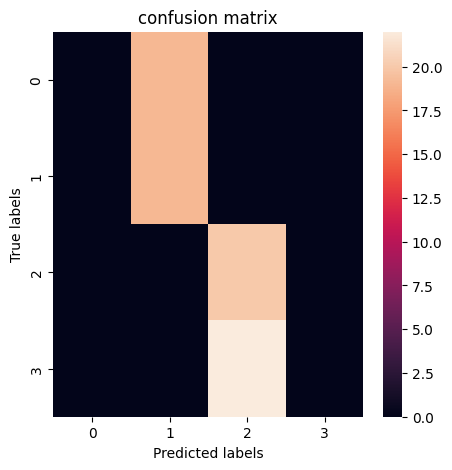

Model: PCA-mlp : 10 compontents
accuracy_score: 0.8125
precision_score: 0.8264705882352942
recall_score: 0.8238636363636364
f1_score: 0.8205128205128205


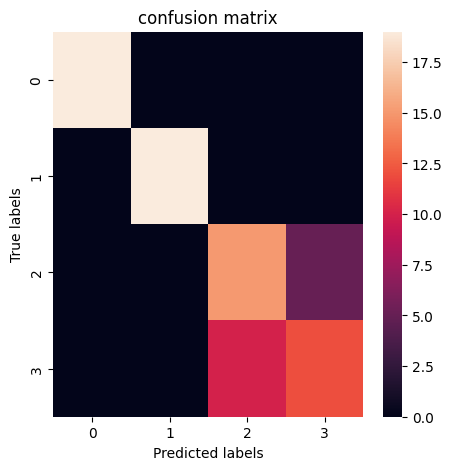

Model: PCA-mlp : all compontents
accuracy_score: 0.8125
precision_score: 0.819327731092437
recall_score: 0.8186602870813398
f1_score: 0.8168184488836663


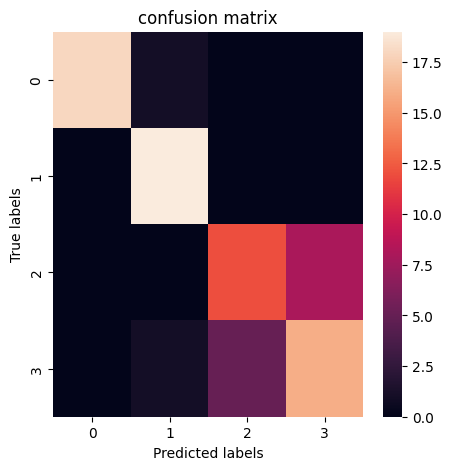

In [35]:
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(x_pca, labels, test_size=0.2, random_state=42)


### knn and pca with 2 components
knn_pca_2 = KNeighborsClassifier(4)
Classifier(knn_pca_2, pca_x_train[:,0:1], pca_y_train, pca_x_test[:,0:1], pca_y_test, 'PCA-knn : 2 compontents')

# ### knn and pca with 10 components
knn_pca_10 = KNeighborsClassifier(4)
Classifier(knn_pca_10, pca_x_train[:,0:9], pca_y_train, pca_x_test[:,0:9], pca_y_test, 'PCA-knn : 10 compontents')

# ### knn and pca with all components
knn_pca_all = KNeighborsClassifier(4)
Classifier(knn_pca_all, pca_x_train, pca_y_train, pca_x_test, pca_y_test, 'PCA-knn : all compontents')



# ### svc and pca with 2 components
svc_pca_2 = SVC(kernel='linear')
Classifier(svc_pca_2, pca_x_train[:,0:1], pca_y_train, pca_x_test[:,0:1], pca_y_test, 'PCA-svc : 2 compontents')

# ### svc and pca with 10 components
svc_pca_10 = SVC(kernel='linear')
Classifier(svc_pca_10, pca_x_train[:,0:9], pca_y_train, pca_x_test[:,0:9], pca_y_test, 'PCA-svc : 10 compontents')

# ### svc and pca with all components
svc_pca_all = SVC(kernel='linear')
Classifier(svc_pca_all, pca_x_train, pca_y_train, pca_x_test, pca_y_test, 'PCA-svc : all compontents')



# ### mlp and pca with 2 components
mlp_pca_2 = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(mlp_pca_2, pca_x_train[:,0:1], pca_y_train, pca_x_test[:,0:1], pca_y_test, 'PCA-mlp : 2 compontents')

# ### svc and pca with 10 components
mlp_pca_10 = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(mlp_pca_10, pca_x_train[:,0:9], pca_y_train, pca_x_test[:,0:9], pca_y_test, 'PCA-mlp : 10 compontents')

# ### svc and pca with all components
mlp_pca_all = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(mlp_pca_all, pca_x_train, pca_y_train, pca_x_test, pca_y_test, 'PCA-mlp : all compontents')



### PCA

| Model                      | accuracy_score | precision_score | recall_score | f1_score         |
|----------------------------|----------------|-----------------|--------------|------------------|
| PCA-knn : 2 components     | 0.7625         | 0.7796          | 0.7773       | 0.7706           |
| PCA-knn : 10 components    | 0.8875         | 0.8929          | 0.8932       | 0.8928           |
| PCA-knn : all components  | 0.9            | 0.9045           | 0.9045       | 0.9045           |
| PCA-svc : 2 components     | 0.75           |/!\ 0.6310 /!\   | 0.75         | 0.6719           |
| PCA-svc : 10 components    | 0.8875         | 0.8953          | 0.8943       | 0.8928           |
| PCA-svc : all components  | 0.925          | 0.9423           | 0.9318       | 0.9279           |
| PCA-mlp : 2 components     | 0.4875         |/!\ 0.2440 /!\   | 0.5          | 0.3280           |
| PCA-mlp : 10 components    | 0.8125         | 0.8265          | 0.8239       | 0.8205           |
| PCA-mlp : all components  | 0.8125         | 0.8193          | 0.8187       | 0.8168           |



## All performance results:
### Resized
| Model              | accuracy_score | precision_score | recall_score | f1_score         |
|--------------------|----------------|-----------------|--------------|------------------|
| knn-3              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-4              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-5              | 0.8875         | 0.8930          | 0.8920       | 0.8923           |
| SVC-linear         | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| SVC-poly           | 0.95           | 0.9583          | 0.9545       | 0.9523           |
| SVC-rbf            | 0.5125         |/!\ 0.5819 /!\          | 0.5341       | 0.4334           |
| MLP: 100           | 0.675          | 0.8322          | 0.6722       | 0.6099           |
| MLP: (100, 100)    | 0.8125         | 0.8778          | 0.8206       | 0.8187           |
| MLP: (100, 100, 100)| 0.85           | 0.8771          | 0.8477       | 0.8495           |

### Flattened

| Model              | accuracy_score | precision_score | recall_score | f1_score         |
|--------------------|----------------|-----------------|--------------|------------------|
| knn-3              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-4              | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| knn-5              | 0.8875         | 0.8930          | 0.8920       | 0.8923           |
| SVC-linear         | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| SVC-poly           | 0.95           | 0.9583          | 0.9545       | 0.9523           |
| SVC-rbf            | 0.5125         | /!\ 0.5819 /!\          | 0.5341       | 0.4334           |
| MLP: 100           | 0.675          | 0.8322          | 0.6722       | 0.6099           |
| MLP: (100, 100)    | 0.8125         | 0.8778          | 0.8206       | 0.8187           |
| MLP: (100, 100, 100)| 0.85           | 0.8771          | 0.8477       | 0.8495           |

### Hog results
| Model               | accuracy_score | precision_score | recall_score | f1_score         |
|---------------------|----------------|-----------------|--------------|------------------|
| hog 16_4: knn       | 0.8875         | 0.9093          | 0.8966       | 0.8913           |
| hog 16_4: SVC       | 0.9375         | 0.95            | 0.9432       | 0.9402           |
| hog 16_8: knn       | 0.8625         | 0.8946          | 0.8739       | 0.8653           |
| hog 16_8: SVC       | 0.9375         | 0.95            | 0.9432       | 0.9402           |
| hog 32_4: knn       | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| hog 32_4: SVC       | 0.8875         | 0.9224          | 0.8977       | 0.8898           |
| hog 32_8: knn       | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| hog 32_8: SVC       | 0.9            | 0.9286          | 0.9091       | 0.9028           |

### PCA

| Model                      | accuracy_score | precision_score | recall_score | f1_score         |
|----------------------------|----------------|-----------------|--------------|------------------|
| PCA-knn : 2 components     | 0.7625         | 0.7796          | 0.7773       | 0.7706           |
| PCA-knn : 10 components    | 0.8875         | 0.8929          | 0.8932       | 0.8928           |
| PCA-knn : all components  | 0.9            | 0.9045          | 0.9045       | 0.9045           |
| PCA-svc : 2 components     | 0.75           | /!\ 0.6310 /!\ | 0.75         | 0.6719           |
| PCA-svc : 10 components    | 0.8875         | 0.8953          | 0.8943       | 0.8928           |
| PCA-svc : all components  | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| PCA-mlp : 2 components     | 0.4875         |/!\ 0.2440 /!\   | 0.5          | 0.3280           |
| PCA-mlp : 10 components    | 0.8125         | 0.8265          | 0.8239       | 0.8205           |
| PCA-mlp : all components  | 0.8125         | 0.8193          | 0.8187       | 0.8168           |




**Questions:**

**1. What is the best performing model trained on the flattened images? Why?**

The best performing model trained on the flattened images is the *SVC with polynomial kernel* which outperforms all the other models for all the metrics.
Looking at the confusion matrix, we can see it has perfect predictions on the classes 0 and 1, and very few wrong predictions in differentiating classes 2 and 3.

Note that the *SVC with linear kernel* is the second most efficient model, and has very closed performances.

**2. What is the best performing model using the HOG features? With which HOG set? Why?**

Once again, the *SVC* (linear kernel only was tested) has the best performances. Regarding the HOG set, the ones with a *size_1 of 16* have exact same performances for 4 and 8 directions, and outperforms the other sets.

Which is not surprising, as we already mentioned in task 3: the loss of information with the bigger size of cells is very significant.

**3. What is the best performing model using PCA features? With how many components? Why?**

For each model using PCA: the more components, the better the performances. Indeed, each additional component helps in refining the prediction, even if the latest have very little influence. Considering 10 components out of 400 is already a very significant feature reduction.

Then, once again, the best family of models is the *SVC*.

**4. Regarding the models trained with PCA features, analyze the SVC performance.**

Compare to other kind of model, the SVC seems to be more sensitive to the number of components. While for the MLP, similar performances are seen with 10 and all components, there is still a significant gain between 10 and all components for the SVC.

Model: PCA-svc-poly : 2 components
accuracy_score: 0.725
precision_score: 0.5941142191142191
recall_score: 0.75
f1_score: 0.6511988424968995


/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


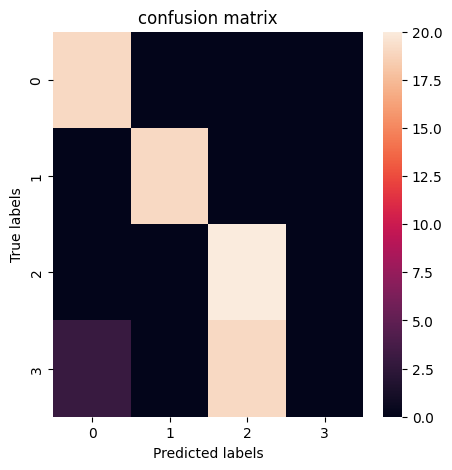

Model: PCA-svc-poly : 10 components
accuracy_score: 0.925
precision_score: 0.9305555555555556
recall_score: 0.9272727272727272
f1_score: 0.9279176201372997


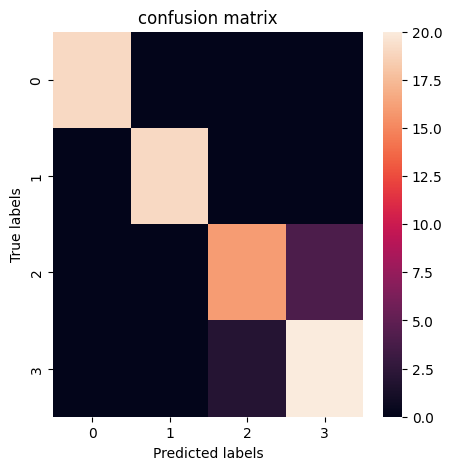

Model: PCA-svc-poly : all components
accuracy_score: 0.95
precision_score: 0.9583333333333334
recall_score: 0.9545454545454546
f1_score: 0.9522727272727273


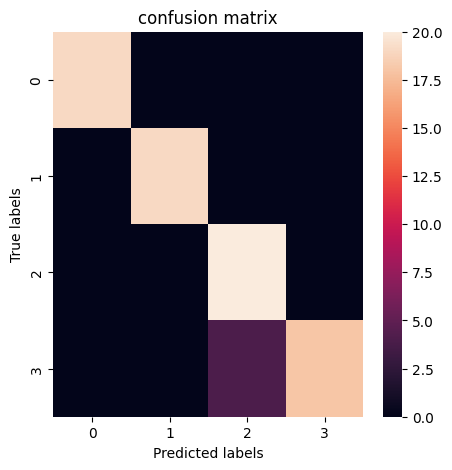

Model: PCA-svc-rbf : 2 components
accuracy_score: 0.8
precision_score: 0.8888888888888888
recall_score: 0.8181818181818181
f1_score: 0.7857142857142857


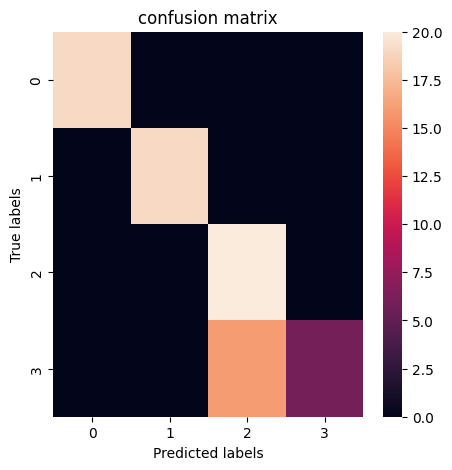

Model: PCA-svc-rbf : 10 components
accuracy_score: 0.9125
precision_score: 0.9193363844393593
recall_score: 0.9181818181818182
f1_score: 0.9166193987521272


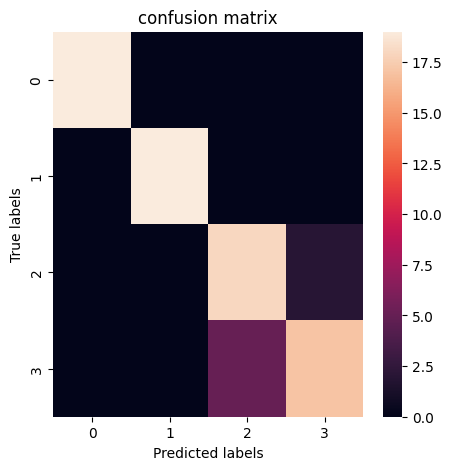

Model: PCA-svc-rbf : all components
accuracy_score: 0.9375
precision_score: 0.95
recall_score: 0.9431818181818181
f1_score: 0.9401709401709402


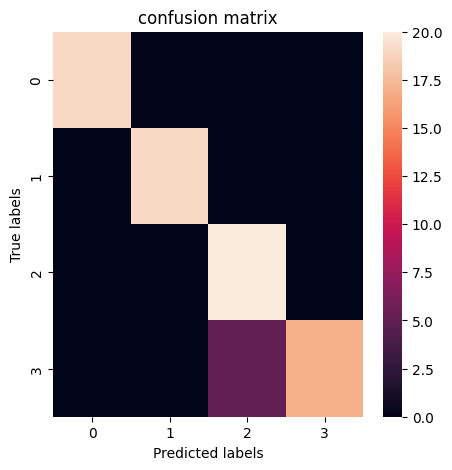

In [36]:
# ### svc and pca with 2 components
svc_pca_poly_2 = SVC(kernel='poly')
Classifier(svc_pca_poly_2, pca_x_train[:,0:1], pca_y_train, pca_x_test[:,0:1], pca_y_test, 'PCA-svc-poly : 2 components')

# ### svc and pca with 10 components
svc_pca_poly_10 = SVC(kernel='poly')
Classifier(svc_pca_poly_10, pca_x_train[:,0:9], pca_y_train, pca_x_test[:,0:9], pca_y_test, 'PCA-svc-poly : 10 components')

# ### svc and pca with all components
svc_pca_poly_all = SVC(kernel='poly')
Classifier(svc_pca_poly_all, pca_x_train, pca_y_train, pca_x_test, pca_y_test, 'PCA-svc-poly : all components')

# ### svc and pca with 2 components
svc_pca_rbf_2 = SVC(kernel='rbf')
Classifier(svc_pca_rbf_2, pca_x_train[:,0:1], pca_y_train, pca_x_test[:,0:1], pca_y_test, 'PCA-svc-rbf : 2 components')

# ### svc and pca with 10 components
svc_pca_rbf_10 = SVC(kernel='rbf')
Classifier(svc_pca_rbf_10, pca_x_train[:,0:9], pca_y_train, pca_x_test[:,0:9], pca_y_test, 'PCA-svc-rbf : 10 components')

# ### svc and pca with all components
svc_pca_rbf_all = SVC(kernel='rbf')
Classifier(svc_pca_rbf_all, pca_x_train, pca_y_train, pca_x_test, pca_y_test, 'PCA-svc-rbf : all components')



| Model                          | accuracy_score | precision_score | recall_score | f1_score         |
|--------------------------------|----------------|-----------------|--------------|------------------|
| PCA-svc-lin : 2 components     | 0.75           | /!\ 0.6310 /!\ | 0.75         | 0.6719           |
| PCA-svc-lin : 10 components    | 0.8875         | 0.8953          | 0.8943       | 0.8928           |
| PCA-svc-lin : all components  | 0.925          | 0.9423          | 0.9318       | 0.9279           |
| PCA-svc-poly : 2 components     | 0.725          | /!\ 0.5941 /!\ | 0.75         | 0.6512           |
| PCA-svc-poly : 10 components    | 0.925          | 0.9306          | 0.9273       | 0.9279           |
| PCA-svc-poly : all components  | 0.95           | 0.9583          | 0.9545       | 0.9523           |
| PCA-svc-rbf : 2 components     | 0.8            | 0.8889          | 0.8182       | 0.7857           |
| PCA-svc-rbf : 10 components    | 0.9125         | 0.9193          | 0.9182       | 0.9166           |
| PCA-svc-rbf : all components   | 0.9375         | 0.95            | 0.9432       | 0.9402           |


**5. For the SVC with PCA features, try the RBF and poly kernels in a new cell, using the three variations of the PCA sets. Compare the performances of these kernels? (Iteration limits might be required for poly kernels)**

The best one is with the use of the polynomial kernel followed by RBF and then the linear kernel.

**6. Based on the confusion matrices, can you spot a recurring pattern in the classification results? Relate this pattern with the component plot in task 3 and the original dataset.**

In the confusion matrix, we can see that the models in general are very efficient in identifying class 0 and class 1, and into a class 2-3. The distinction between class 2 and class 3 is more delicate. That confirmed the assumption of task 3 question 3 in which we noted that the bottom right cluster was blurry and probably was related to class 3 and 4.

**7. Explain why higher number of layers/neurons in the MLP does not translate in better accuracy?**

With higher number of layers and neurons, the MLP is overfitting. For example (see hereafter), the confusion matrix is perfect with the training set, which is not the case for the test set.

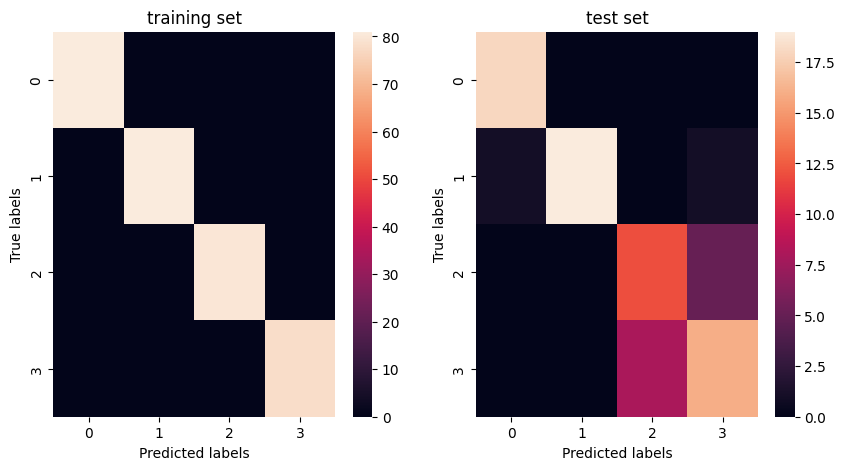

In [37]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(mlp_pca_all.predict(pca_x_train), pca_y_train))
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.title("training set")
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(mlp_pca_all.predict(pca_x_test), pca_y_test))
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.title("test set")
plt.show()

## Bonus - Pneumonia Classification & Grid Search (2 points)
For this bonus task you will have to discard the samples belonging to classes 0 and 1, and assign the 0 and 1 values to classes 2 and 3. Then you will train a KNN classifier, a SVC and an MLP classifier using the grid search algorithm to identify the best hyperparameters for the new task.
Use the following parameter grids:  
− knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}  
− svm_param_grid = {'kernel': ['linear', 'rbf','poly'], 'C': [0.1, 1, 10], 'max_iter':[300]}  
− mlp_param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 'alpha': [0.0001, 0.001, 0.01], 'max_iter':[300]}  
Use the identified parameters for the following tasks.  
    •	Train with normal flattened images  
    •	Train with HOG  
    •	Train with PCA  
Compare and analyze the best-performing hyperparameter set for each model and training data. Identify the most suitable model and corresponding feature set for this CodeLab. Can you propose another feature engineering method to improve the model performance? Explain.  

In [38]:
def create_sub_sets(X, labels):
    new_X = []
    new_labels = []
    for i, label in enumerate(labels):
        if label not in [2,3]:
            continue
        new_labels.append(label - 2)
        new_X.append(X[i])
    return np.array(new_X), np.array(new_labels)

x_origin = {'x_flattened': x_flattened,
            'hog_features_16_8': hog_features_16_8,
            'hog_features_16_4': hog_features_16_4,
            'x_pca': x_pca}

x_sub = {}
for data_set_name in x_origin:
    x_sub[data_set_name], sub_labels = create_sub_sets(x_origin[data_set_name], labels)

In [39]:
from itertools import product

def generate_param_combinations(param_dict):
    # Extract parameter names and their corresponding lists of values
    param_names = list(param_dict.keys())
    param_values = list(param_dict.values())

    # Generate all combinations of parameter values
    param_combinations = list(product(*param_values))

    # Create a list of dictionaries with parameter names and values
    param_dicts = []
    for combo in param_combinations:
        param_dict = dict(zip(param_names, combo))
        param_dicts.append(param_dict)

    return param_dicts

model_param = {'knn':{
                'model': lambda param:KNeighborsClassifier(**param),
                'params': {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}},
             'svm':{
                 'model': lambda param:SVC(**param),
                 'params': {'kernel': ['linear', 'rbf','poly'], 'C': [0.1, 1, 10], 'max_iter':[300]}},
             'mlp':{
                 'model': lambda param:MLPClassifier(**param),
                 'params':{'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 'alpha': [0.0001, 0.001, 0.01], 'max_iter':[300]}
             }
}



In [40]:
def train(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return {'accuracy_score': accuracy_score(y_test, y_pred),
            'precision_score': precision_score(y_test, y_pred),
            'recall_score': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred)}

def train_all(x_orig, sub_labels, model_param):
    result={}
    for orig in x_orig:
        train_and_test = train_test_split(x_sub[orig], sub_labels, test_size=0.25, random_state=42)
        for mod in model_param:
            for param in generate_param_combinations(model_param[mod]['params']):
                model = model_param[mod]['model'](param)
                res = train(model, *train_and_test)
                result[f"{orig} {mod} {param}"] = res
    return result

result = train_all(x_origin, sub_labels, model_param)

/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benoitjeanson/vsCode/TUD/tud/ML for Electrical Engineering/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (

In [41]:
def result_to_md(result):
    md = "| orig - model - param | accuracy_score | precision_score | recall_score | f1_score |"
    md += "\n|---|---|---|---|---|"
    for r in result:
        res = result[r]
        md += f"\n| {r}  | {res['accuracy_score']} | {res['precision_score']} | {res['recall_score']} | {res['f1_score']} |"
    return md

print(result_to_md(result))
    
    # /!\ should add Tol = 1e-3 !!!

| orig - model - param | accuracy_score | precision_score | recall_score | f1_score |
|---|---|---|---|---|
| x_flattened knn {'n_neighbors': 1}  | 0.84 | 0.8333333333333334 | 0.8928571428571429 | 0.8620689655172413 |
| x_flattened knn {'n_neighbors': 3}  | 0.82 | 0.7878787878787878 | 0.9285714285714286 | 0.8524590163934426 |
| x_flattened knn {'n_neighbors': 5}  | 0.86 | 0.8387096774193549 | 0.9285714285714286 | 0.8813559322033899 |
| x_flattened knn {'n_neighbors': 7}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| x_flattened knn {'n_neighbors': 9}  | 0.84 | 0.8333333333333334 | 0.8928571428571429 | 0.8620689655172413 |
| x_flattened knn {'n_neighbors': 11}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_flattened knn {'n_neighbors': 13}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_flattened knn {'n_neighbors': 15}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| x_flatt

| orig - model - param | accuracy_score | precision_score | recall_score | f1_score |
|---|---|---|---|---|
| x_flattened knn {'n_neighbors': 1}  | 0.84 | 0.8333333333333334 | 0.8928571428571429 | 0.8620689655172413 |
| x_flattened knn {'n_neighbors': 3}  | 0.82 | 0.7878787878787878 | 0.9285714285714286 | 0.8524590163934426 |
| x_flattened knn {'n_neighbors': 5}  | 0.86 | 0.8387096774193549 | 0.9285714285714286 | 0.8813559322033899 |
| x_flattened knn {'n_neighbors': 7}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| x_flattened knn {'n_neighbors': 9}  | 0.84 | 0.8333333333333334 | 0.8928571428571429 | 0.8620689655172413 |
| x_flattened knn {'n_neighbors': 11}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_flattened knn {'n_neighbors': 13}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_flattened knn {'n_neighbors': 15}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| x_flattened svm {'kernel': 'linear', 'C': 0.1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'linear', 'C': 1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'linear', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'rbf', 'C': 0.1, 'max_iter': 300}  | 0.52 | 1.0 | 0.14285714285714285 | 0.25 |
| x_flattened svm {'kernel': 'rbf', 'C': 1, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| x_flattened svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'poly', 'C': 0.1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'poly', 'C': 1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'poly', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened mlp {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'max_iter': 300}  | 0.44 | 0.0 | 0.0 | 0.0 |
| x_flattened mlp {'hidden_layer_sizes': (100,), 'alpha': 0.001, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| x_flattened mlp {'hidden_layer_sizes': (100,), 'alpha': 0.01, 'max_iter': 300}  | 0.78 | 1.0 | 0.6071428571428571 | 0.7555555555555554 |
| x_flattened mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_flattened mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.8 | 1.0 | 0.6428571428571429 | 0.782608695652174 |
| x_flattened mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.44 | 0.0 | 0.0 | 0.0 |
| x_flattened mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.44 | 0.0 | 0.0 | 0.0 |
| x_flattened mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.72 | 1.0 | 0.5 | 0.6666666666666666 |
| x_flattened mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.44 | 0.0 | 0.0 | 0.0 |
| hog_features_16_8 knn {'n_neighbors': 1}  | 0.78 | 0.8695652173913043 | 0.7142857142857143 | 0.7843137254901961 |
| hog_features_16_8 knn {'n_neighbors': 3}  | 0.8 | 0.9090909090909091 | 0.7142857142857143 | 0.8 |
| hog_features_16_8 knn {'n_neighbors': 5}  | 0.78 | 0.9473684210526315 | 0.6428571428571429 | 0.7659574468085106 |
| hog_features_16_8 knn {'n_neighbors': 7}  | 0.84 | 0.9545454545454546 | 0.75 | 0.84 |
| hog_features_16_8 knn {'n_neighbors': 9}  | 0.84 | 1.0 | 0.7142857142857143 | 0.8333333333333333 |
| hog_features_16_8 knn {'n_neighbors': 11}  | 0.82 | 0.9523809523809523 | 0.7142857142857143 | 0.8163265306122449 |
| hog_features_16_8 knn {'n_neighbors': 13}  | 0.84 | 1.0 | 0.7142857142857143 | 0.8333333333333333 |
| hog_features_16_8 knn {'n_neighbors': 15}  | 0.84 | 1.0 | 0.7142857142857143 | 0.8333333333333333 |
| hog_features_16_8 svm {'kernel': 'linear', 'C': 0.1, 'max_iter': 300}  | 0.9 | 1.0 | 0.8214285714285714 | 0.9019607843137255 |
| hog_features_16_8 svm {'kernel': 'linear', 'C': 1, 'max_iter': 300}  | 0.86 | 0.92 | 0.8214285714285714 | 0.8679245283018867 |
| hog_features_16_8 svm {'kernel': 'linear', 'C': 10, 'max_iter': 300}  | 0.86 | 0.92 | 0.8214285714285714 | 0.8679245283018867 |
| hog_features_16_8 svm {'kernel': 'rbf', 'C': 0.1, 'max_iter': 300}  | 0.7 | 1.0 | 0.4642857142857143 | 0.6341463414634146 |
| hog_features_16_8 svm {'kernel': 'rbf', 'C': 1, 'max_iter': 300}  | 0.9 | 1.0 | 0.8214285714285714 | 0.9019607843137255 |
| hog_features_16_8 svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_8 svm {'kernel': 'poly', 'C': 0.1, 'max_iter': 300}  | 0.9 | 1.0 | 0.8214285714285714 | 0.9019607843137255 |
| hog_features_16_8 svm {'kernel': 'poly', 'C': 1, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 svm {'kernel': 'poly', 'C': 10, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100,), 'alpha': 0.001, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100,), 'alpha': 0.01, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.9 | 0.9259259259259259 | 0.8928571428571429 | 0.9090909090909091 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| hog_features_16_8 mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_4 knn {'n_neighbors': 1}  | 0.8 | 0.9090909090909091 | 0.7142857142857143 | 0.8 |
| hog_features_16_4 knn {'n_neighbors': 3}  | 0.8 | 0.95 | 0.6785714285714286 | 0.7916666666666667 |
| hog_features_16_4 knn {'n_neighbors': 5}  | 0.82 | 0.9523809523809523 | 0.7142857142857143 | 0.8163265306122449 |
| hog_features_16_4 knn {'n_neighbors': 7}  | 0.8 | 0.95 | 0.6785714285714286 | 0.7916666666666667 |
| hog_features_16_4 knn {'n_neighbors': 9}  | 0.82 | 0.9523809523809523 | 0.7142857142857143 | 0.8163265306122449 |
| hog_features_16_4 knn {'n_neighbors': 11}  | 0.86 | 1.0 | 0.75 | 0.8571428571428571 |
| hog_features_16_4 knn {'n_neighbors': 13}  | 0.86 | 1.0 | 0.75 | 0.8571428571428571 |
| hog_features_16_4 knn {'n_neighbors': 15}  | 0.84 | 1.0 | 0.7142857142857143 | 0.8333333333333333 |
| hog_features_16_4 svm {'kernel': 'linear', 'C': 0.1, 'max_iter': 300}  | 0.88 | 1.0 | 0.7857142857142857 | 0.88 |
| hog_features_16_4 svm {'kernel': 'linear', 'C': 1, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 svm {'kernel': 'linear', 'C': 10, 'max_iter': 300}  | 0.86 | 0.92 | 0.8214285714285714 | 0.8679245283018867 |
| hog_features_16_4 svm {'kernel': 'rbf', 'C': 0.1, 'max_iter': 300}  | 0.84 | 1.0 | 0.7142857142857143 | 0.8333333333333333 |
| hog_features_16_4 svm {'kernel': 'rbf', 'C': 1, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| hog_features_16_4 svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| hog_features_16_4 svm {'kernel': 'poly', 'C': 0.1, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| hog_features_16_4 svm {'kernel': 'poly', 'C': 1, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 svm {'kernel': 'poly', 'C': 10, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100,), 'alpha': 0.001, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100,), 'alpha': 0.01, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.88 | 0.9230769230769231 | 0.8571428571428571 | 0.888888888888889 |
| hog_features_16_4 mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.88 | 0.9583333333333334 | 0.8214285714285714 | 0.8846153846153847 |
| x_pca knn {'n_neighbors': 1}  | 0.84 | 0.8333333333333334 | 0.8928571428571429 | 0.8620689655172413 |
| x_pca knn {'n_neighbors': 3}  | 0.82 | 0.7878787878787878 | 0.9285714285714286 | 0.8524590163934426 |
| x_pca knn {'n_neighbors': 5}  | 0.86 | 0.8387096774193549 | 0.9285714285714286 | 0.8813559322033899 |
| x_pca knn {'n_neighbors': 7}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| x_pca knn {'n_neighbors': 9}  | 0.84 | 0.8333333333333334 | 0.8928571428571429 | 0.8620689655172413 |
| x_pca knn {'n_neighbors': 11}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_pca knn {'n_neighbors': 13}  | 0.84 | 0.8571428571428571 | 0.8571428571428571 | 0.8571428571428571 |
| x_pca knn {'n_neighbors': 15}  | 0.86 | 0.8888888888888888 | 0.8571428571428571 | 0.8727272727272727 |
| x_pca svm {'kernel': 'linear', 'C': 0.1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'linear', 'C': 1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'linear', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'rbf', 'C': 0.1, 'max_iter': 300}  | 0.44 | 0.0 | 0.0 | 0.0 |
| x_pca svm {'kernel': 'rbf', 'C': 1, 'max_iter': 300}  | 0.9 | 0.96 | 0.8571428571428571 | 0.9056603773584904 |
| x_pca svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'poly', 'C': 0.1, 'max_iter': 300}  | 0.78 | 0.9473684210526315 | 0.6428571428571429 | 0.7659574468085106 |
| x_pca svm {'kernel': 'poly', 'C': 1, 'max_iter': 300}  | 0.9 | 0.8709677419354839 | 0.9642857142857143 | 0.9152542372881356 |
| x_pca svm {'kernel': 'poly', 'C': 10, 'max_iter': 300}  | 0.92 | 0.9285714285714286 | 0.9285714285714286 | 0.9285714285714286 |
| x_pca mlp {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'max_iter': 300}  | 0.78 | 0.8148148148148148 | 0.7857142857142857 | 0.7999999999999999 |
| x_pca mlp {'hidden_layer_sizes': (100,), 'alpha': 0.001, 'max_iter': 300}  | 0.84 | 0.8846153846153846 | 0.8214285714285714 | 0.8518518518518519 |
| x_pca mlp {'hidden_layer_sizes': (100,), 'alpha': 0.01, 'max_iter': 300}  | 0.72 | 0.8181818181818182 | 0.6428571428571429 | 0.7200000000000001 |
| x_pca mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.84 | 0.9545454545454546 | 0.75 | 0.84 |
| x_pca mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.72 | 0.7916666666666666 | 0.6785714285714286 | 0.7307692307692307 |
| x_pca mlp {'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.82 | 0.8064516129032258 | 0.8928571428571429 | 0.8474576271186439 |
| x_pca mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.0001, 'max_iter': 300}  | 0.82 | 0.8275862068965517 | 0.8571428571428571 | 0.8421052631578947 |
| x_pca mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.001, 'max_iter': 300}  | 0.84 | 0.9166666666666666 | 0.7857142857142857 | 0.8461538461538461 |
| x_pca mlp {'hidden_layer_sizes': (100, 100, 100), 'alpha': 0.01, 'max_iter': 300}  | 0.82 | 0.88 | 0.7857142857142857 | 0.830188679245283 |

### Best results (accuracy>=.92)

| orig - model - param | accuracy_score | precision_score | recall_score | f1_score |
|---|---|---|---|---|
| x_flattened svm {'kernel': 'linear', 'C': 0.1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'linear', 'C': 1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'linear', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'poly', 'C': 0.1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'poly', 'C': 1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened svm {'kernel': 'poly', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_flattened mlp {'hidden_layer_sizes': (100,), 'alpha': 0.001, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| hog_features_16_4 svm {'kernel': 'rbf', 'C': 1, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| hog_features_16_4 svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| hog_features_16_4 svm {'kernel': 'poly', 'C': 0.1, 'max_iter': 300}  | 0.92 | 1.0 | 0.8571428571428571 | 0.923076923076923 |
| x_pca svm {'kernel': 'linear', 'C': 0.1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'linear', 'C': 1, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'linear', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'rbf', 'C': 10, 'max_iter': 300}  | 0.94 | 1.0 | 0.8928571428571429 | 0.9433962264150945 |
| x_pca svm {'kernel': 'poly', 'C': 10, 'max_iter': 300}  | 0.92 | 0.9285714285714286 | 0.9285714285714286 | 0.9285714285714286 |
